# Importing Libraries and Loading Dataset

In [3]:
##%% Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull, QhullError


# Load the dataset

In [4]:
file_path = "data/Animation_Movies_After_Phase1.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Dataset Loaded Successfully!")
df.head()


Dataset Loaded Successfully!


id         title  vote_average  vote_count    status release_date  \
0  150540    Inside Out         7.922   19.208098  Released   2015-06-09   
1   14160            Up         7.949   19.208098  Released   2009-05-28   
2      12  Finding Nemo         7.824   19.208098  Released   2003-05-30   
3  354912          Coco         8.222   19.208098  Released   2017-10-27   
4   10681        WALL·E         8.078   19.208098  Released   2008-06-22   

        revenue    runtime  adult        budget  ... content_complexity  \
0  8.850803e+07  21.009978  False  1.954684e+07  ...                5.0   
1  8.850803e+07  21.009978  False  1.954684e+07  ...                4.0   
2  8.850803e+07  21.009978  False  1.954684e+07  ...                2.0   
3  8.850803e+07  21.009978  False  1.954684e+07  ...                6.0   
4  8.850803e+07  21.009978  False  1.954684e+07  ...                3.0   

  popularity_normalized runtime_normalized  vote_average_normalized  \
0              0.406107           0.212312                 1.572179   
1              0.406107           0.212312                 1.580282   
2              0.406107           0.212312                 1.542766   
3              0.406107           0.212312                 1.662216   
4              0.406107           0.212312                 1.618998   

  budget_normalized revenue_normalized vote_count_normalized Year_normalized  \
0          0.963383           0.970238              0.619616        0.925676   
1          0.963383           0.970238              0.619616        0.885135   
2          0.963383           0.970238              0.619616        0.844595   
3          0.963383           0.970238              0.619616        0.939189   
4          0.963383           0.970238              0.619616        0.878378   

   vote_count_bins release_year  
0     (18.6, 21.7]         2015  
1     (18.6, 21.7]         2009  
2     (18.6, 21.7]         2003  
3     (18.6, 21.7]         2017  
4     (18.6, 21.7]         2008  

[5 rows x 47 columns]

# Check for missing values

In [5]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
processed_overview    62
dtype: int64


# Feature Selection: Genre and Content Similarity
# Features: genres, runtime_normalized, content_complexity


In [6]:
##%% Genre and Content Similarity
scaler = MinMaxScaler()
onehot_encoder = OneHotEncoder(sparse_output=False)

selected_features_genres = ['runtime_normalized', 'content_complexity']
encoded_genres = onehot_encoder.fit_transform(df[['genres']])
encoded_genres_df = pd.DataFrame(encoded_genres, columns=onehot_encoder.get_feature_names_out(['genres']))

# Combine numerical features with encoded genres
features_genres = pd.concat([df[selected_features_genres], encoded_genres_df], axis=1)
normalized_features_genres = scaler.fit_transform(features_genres)
print("Features for genre and content similarity normalized.")


Features for genre and content similarity normalized.


# Feature Selection: Commercial and Popularity Similarity
# Features: budget_normalized, revenue_normalized, ROI, popularity_normalized


In [7]:
##%% Commercial and Popularity Similarity
selected_features_commercial = ['budget_normalized', 'revenue_normalized', 'ROI', 'popularity_normalized']
features_commercial = df[selected_features_commercial]
normalized_features_commercial = scaler.fit_transform(features_commercial)
print("Features for commercial and popularity similarity normalized.")


Features for commercial and popularity similarity normalized.


# Feature Selection: General Combination
# Features: genres, popularity_normalized, vote_average_normalized, budget_normalized, runtime_normalized


In [8]:
##%% General Combination
selected_features_combined = ['popularity_normalized', 'vote_average_normalized', 'budget_normalized', 'runtime_normalized']
features_combined = pd.concat([df[selected_features_combined], encoded_genres_df], axis=1)
normalized_features_combined = scaler.fit_transform(features_combined)
print("Features for general combination similarity normalized.")


Features for general combination similarity normalized.


# Feature Selection: Temporal Analysis (Pure)
# Features: release_year, release_season


In [9]:
##%% Temporal Analysis
selected_features_time = ['release_year', 'release_season']
encoded_season = onehot_encoder.fit_transform(df[['release_season']])
encoded_season_df = pd.DataFrame(encoded_season, columns=onehot_encoder.get_feature_names_out(['release_season']))
features_time = pd.concat([df[['release_year']], encoded_season_df], axis=1)
normalized_features_time = scaler.fit_transform(features_time)
print("Features for temporal analysis normalized.")


Features for temporal analysis normalized.


# Feature Selection: Temporal and Content Analysis
# Features: release_year, release_season, genres, runtime_normalized


In [10]:
##%% Temporal and Content Analysis
selected_features_time_content = ['release_year', 'runtime_normalized']
features_time_content = pd.concat([df[selected_features_time_content], encoded_season_df, encoded_genres_df], axis=1)
normalized_features_time_content = scaler.fit_transform(features_time_content)
print("Features for temporal and content analysis normalized.")


Features for temporal and content analysis normalized.


# Feature Selection: Temporal and Commercial Analysis
# Features: release_year, release_season, budget_normalized, revenue_normalized, popularity_normalized


In [11]:
##%% Temporal and Commercial Analysis
selected_features_time_commercial = ['release_year', 'budget_normalized', 'revenue_normalized', 'popularity_normalized']
features_time_commercial = pd.concat([df[selected_features_time_commercial], encoded_season_df], axis=1)
normalized_features_time_commercial = scaler.fit_transform(features_time_commercial)
print("Features for temporal and commercial analysis normalized.")


Features for temporal and commercial analysis normalized.


In [12]:
##%% Define Feature Sets
feature_sets = {
    "Genre and Content Similarity": normalized_features_genres,
    # "Commercial and Popularity Similarity": normalized_features_commercial,
    "General Combination": normalized_features_combined,
    # "Temporal Analysis (Pure)": normalized_features_time,
    "Temporal and Content Analysis": normalized_features_time_content,
    "Temporal and Commercial Analysis": normalized_features_time_commercial,
}


# K-Means Clustering with Hyperparameter Tuning


In [13]:
##%% K-Means Tuning with Batch Processing
def kmeans_tuning_optimized_batch(normalized_features, max_k=8, batch_size=1000, feature_name=""):
    inertia = []
    silhouette_scores = []
    k_values = range(2, max_k + 1)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(10, normalized_features.shape[1]))
    reduced_features = pca.fit_transform(normalized_features)
    print(f"PCA applied. Reduced dimensions to {reduced_features.shape[1]}.")

    for k in k_values:
        print(f"Running K-Means for k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, max_iter=100)
        kmeans.fit(reduced_features)
        inertia.append(kmeans.inertia_)
        
        # Get cluster labels
        labels = kmeans.labels_
        n_clusters = len(np.unique(labels))
        
        if n_clusters > 1:  # Silhouette Score is only valid if there are at least 2 clusters
            batch_silhouette_scores = []
            for i in range(0, len(reduced_features), batch_size):
                batch = reduced_features[i:i + batch_size]
                batch_labels = labels[i:i + batch_size]
                if len(np.unique(batch_labels)) > 1:  # Ensure batch has >1 unique labels
                    batch_silhouette_scores.extend(silhouette_samples(batch, batch_labels))
            if batch_silhouette_scores:
                avg_silhouette = np.mean(batch_silhouette_scores)
            else:
                avg_silhouette = None
            silhouette_scores.append(avg_silhouette)
        else:
            silhouette_scores.append(None)
            print(f"Silhouette Score cannot be calculated for k={k} as there is only 1 cluster.")

    # Automatically determine the best k using Silhouette Score
    valid_silhouette_scores = [(k, score) for k, score in zip(k_values, silhouette_scores) if score is not None]
    if valid_silhouette_scores:
        optimal_k = max(valid_silhouette_scores, key=lambda x: x[1])[0]
    else:
        optimal_k = 2  # Default to 2 if no valid silhouette scores are available
        print("No valid silhouette scores found. Defaulting optimal k to 2.")

    # Plot Elbow Method (Inertia)
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertia, marker='o')
    plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
    plt.title(f"Elbow Method for Optimal K ({feature_name})")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Silhouette Scores
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, [score if score is not None else 0 for score in silhouette_scores], marker='o')
    if valid_silhouette_scores:
        plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
    plt.title(f"Silhouette Scores for K ({feature_name})")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid()
    plt.show()
    
    return k_values, inertia, silhouette_scores, optimal_k


# DBSCAN Clustering with Optimal Parameters


In [14]:
#%% DBSCAN Tuning with Batch Processing and Separate Plots per Feature Set
def dbscan_tuning_batch(normalized_features, dbscan_params, batch_size=1000, feature_name=""):
    dbscan_results = []

    for params in dbscan_params:
        eps = params["eps"]
        min_samples = params["min_samples"]
        print(f"Testing DBSCAN with eps={eps}, min_samples={min_samples}...")

        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(normalized_features)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Calculate silhouette score in batches if clusters exist
        if n_clusters > 1:
            silhouette_avg = silhouette_score(normalized_features, labels)
        else:
            silhouette_avg = "Not applicable"

        # Append results
        dbscan_results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette_score": silhouette_avg,
            "labels": labels,
        })

        print(f"DBSCAN with eps={eps}, min_samples={min_samples}:")
        print(f"  Number of clusters: {n_clusters}, Noise points: {n_noise}")
        print(f"  Silhouette Score: {silhouette_avg}")

    print(50 * '-')

    # Plot Number of Clusters Heatmap
    eps_values = [r["eps"] for r in dbscan_results]
    min_samples_values = [r["min_samples"] for r in dbscan_results]
    n_clusters_values = [r["n_clusters"] for r in dbscan_results]

    plt.figure(figsize=(10, 6))
    plt.scatter(eps_values, min_samples_values, c=n_clusters_values, cmap='coolwarm', s=100)
    plt.colorbar(label="Number of Clusters")
    plt.title(f"DBSCAN Cluster Count ({feature_name})")
    plt.xlabel("Eps Values")
    plt.ylabel("Min Samples")
    plt.grid()
    plt.show()

    return dbscan_results


Running K-Means tuning for: Genre and Content Similarity
PCA applied. Reduced dimensions to 10.
Running K-Means for k=2...
Running K-Means for k=3...
Running K-Means for k=4...
Running K-Means for k=5...
Running K-Means for k=6...
Running K-Means for k=7...
Running K-Means for k=8...


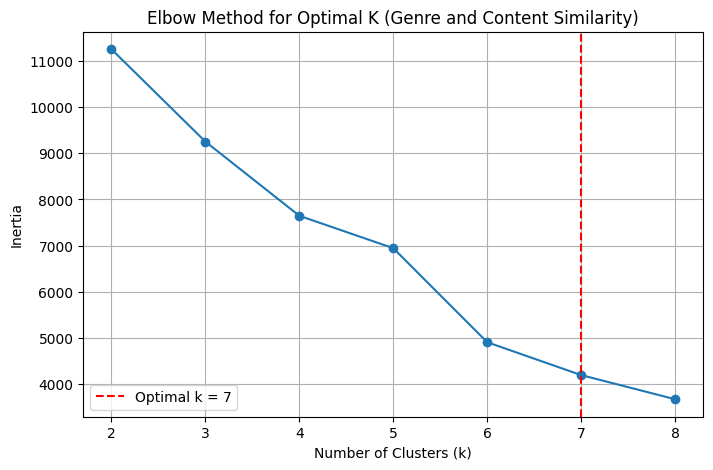

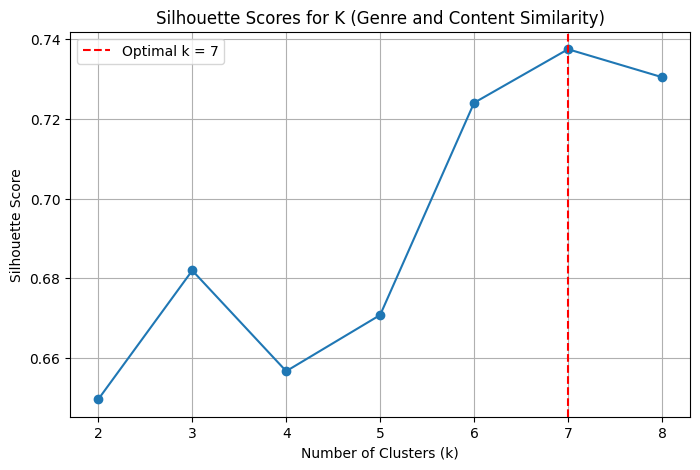


Running K-Means tuning for: General Combination
PCA applied. Reduced dimensions to 10.
Running K-Means for k=2...
Running K-Means for k=3...
Running K-Means for k=4...
Running K-Means for k=5...
Running K-Means for k=6...
Running K-Means for k=7...
Running K-Means for k=8...


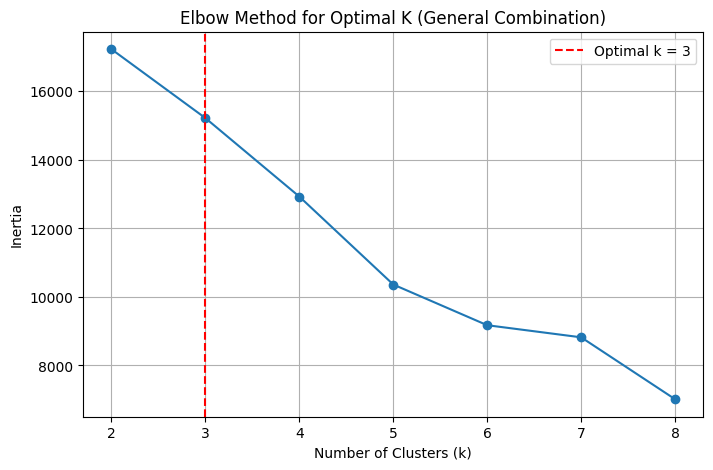

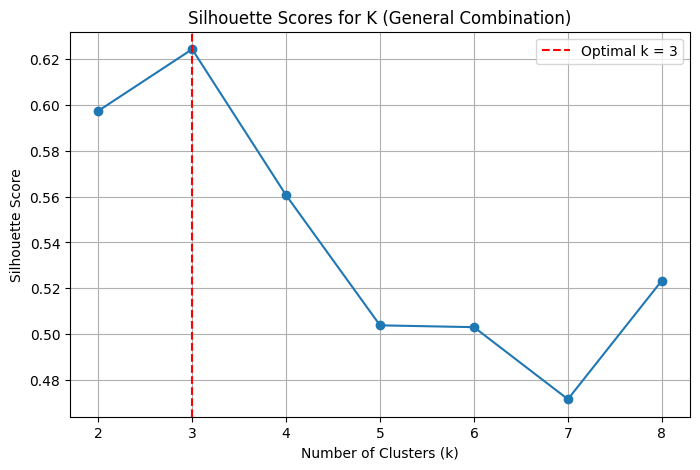


Running K-Means tuning for: Temporal and Content Analysis
PCA applied. Reduced dimensions to 10.
Running K-Means for k=2...
Running K-Means for k=3...
Running K-Means for k=4...
Running K-Means for k=5...
Running K-Means for k=6...
Running K-Means for k=7...
Running K-Means for k=8...


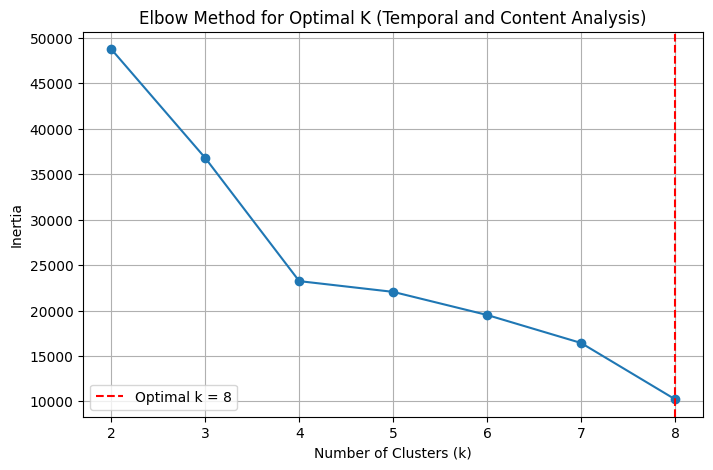

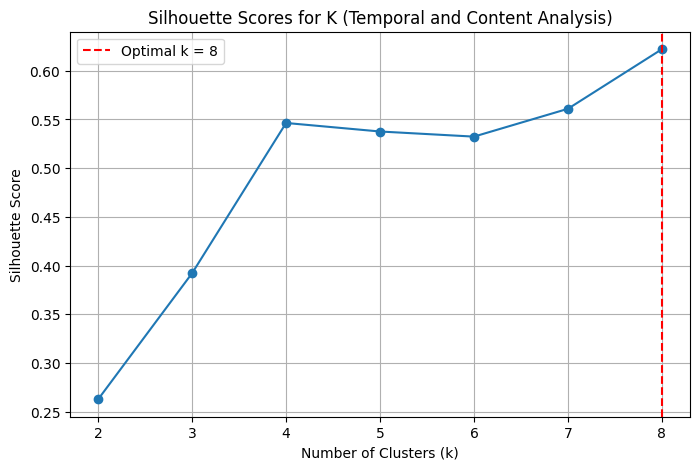


Running K-Means tuning for: Temporal and Commercial Analysis
PCA applied. Reduced dimensions to 8.
Running K-Means for k=2...
Running K-Means for k=3...
Running K-Means for k=4...
Running K-Means for k=5...
Running K-Means for k=6...
Running K-Means for k=7...
Running K-Means for k=8...


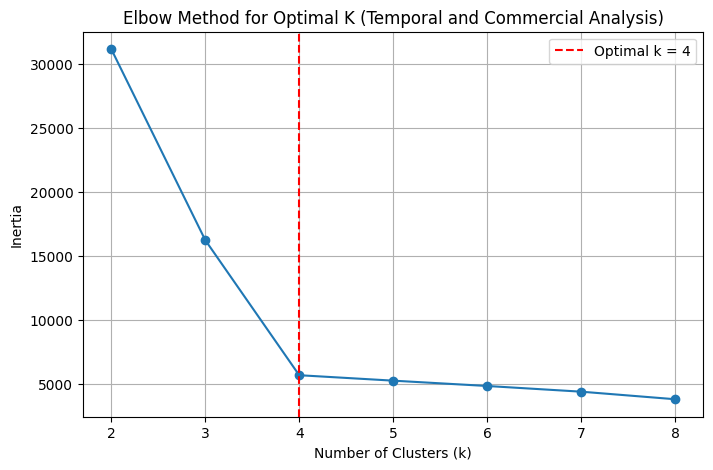

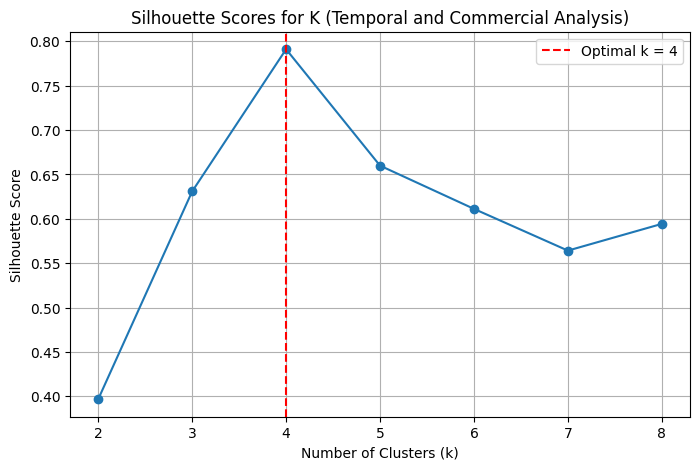

In [13]:
##%% Perform K-Means Clustering
kmeans_results = {}
for feature_name, feature_data in feature_sets.items():
    print(f"\nRunning K-Means tuning for: {feature_name}")
    k_values, inertia, silhouette_scores, optimal_k = kmeans_tuning_optimized_batch(
        feature_data, max_k=8, batch_size=1000, feature_name=feature_name
    )
    
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, max_iter=100)
    cluster_labels = kmeans.fit_predict(feature_data)
    df[f'kmeans_cluster_{feature_name.replace(" ", "_")}'] = cluster_labels
    
    kmeans_results[feature_name] = {
        "k_values": k_values,
        "inertia": inertia,
        "silhouette_scores": silhouette_scores,
        "optimal_k": optimal_k,
        "cluster_labels": cluster_labels,
    }


Generating K-Distance Graph for: Genre and Content Similarity with k=6


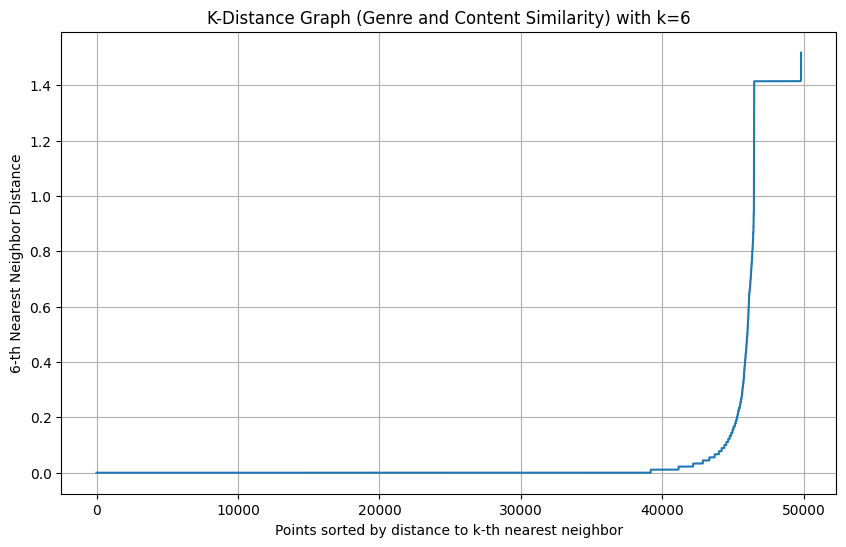

Generating K-Distance Graph for: General Combination with k=2


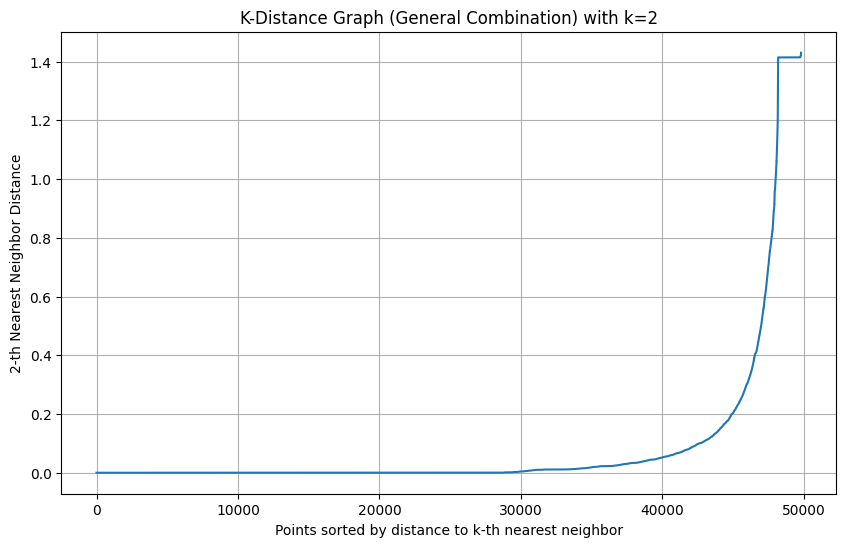

Generating K-Distance Graph for: Temporal and Content Analysis with k=7


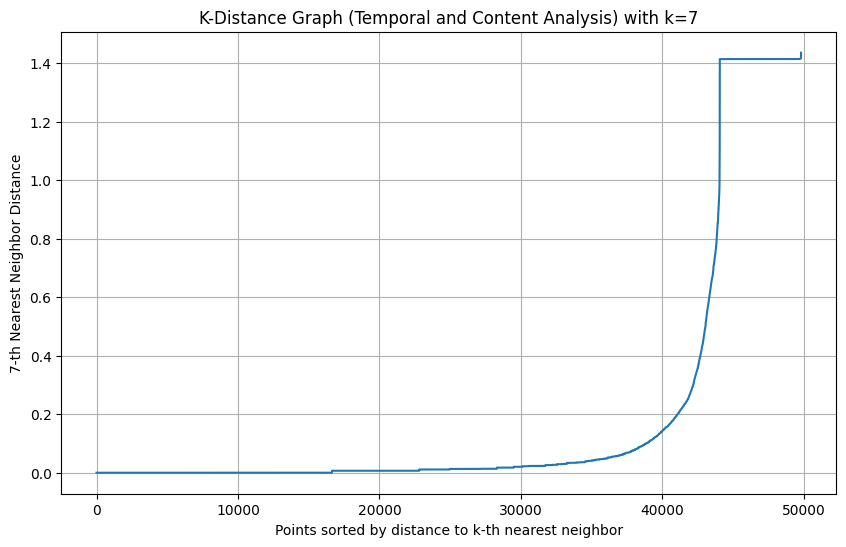

Generating K-Distance Graph for: Temporal and Commercial Analysis with k=3


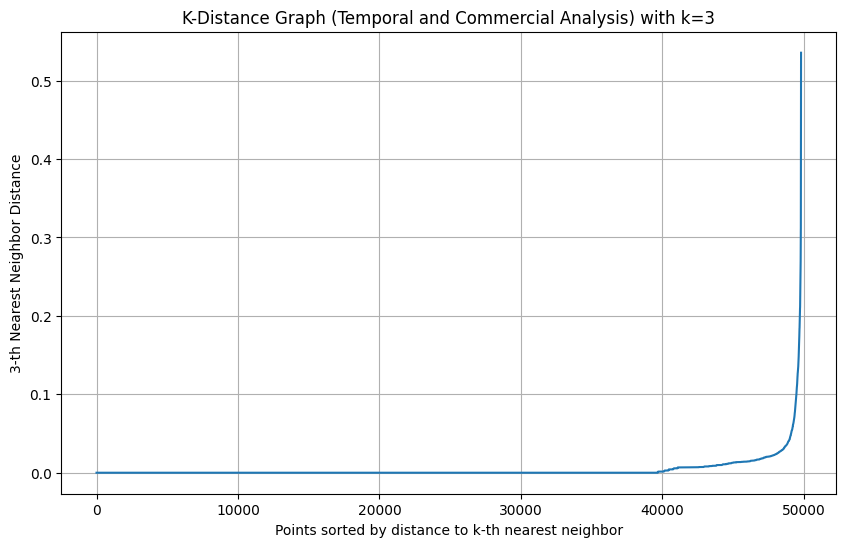

In [14]:
# Loop through each feature set and dynamically adjust k based on K-Means optimal_k
for feature_name, feature_data in feature_sets.items():
    # Extract the optimal_k from K-Means results
    optimal_k = kmeans_results[feature_name]["optimal_k"]  # Optimal number of clusters
    
    # Set k as optimal_k - 1 for DBSCAN (DBSCAN usually uses min_samples - 1)
    k = max(1, optimal_k - 1)  # Ensure k is at least 1
    
    print(f"Generating K-Distance Graph for: {feature_name} with k={k}")
    
    # Fit Nearest Neighbors
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    nearest_neighbors.fit(feature_data)
    distances, indices = nearest_neighbors.kneighbors(feature_data)
    
    # Sort distances for plotting
    distances = np.sort(distances[:, -1])  # Sort the k-th nearest distances
    
    # Plot the K-Distance Graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f"K-Distance Graph ({feature_name}) with k={k}")
    plt.xlabel("Points sorted by distance to k-th nearest neighbor")
    plt.ylabel(f"{k}-th Nearest Neighbor Distance")
    plt.grid()
    plt.show()


In [15]:
##%% Perform DBSCAN Clustering for Each Feature Set
dbscan_params = {
    "Genre and Content Similarity": [
        {"eps": 0.3, "min_samples": 10},
        {"eps": 0.4, "min_samples": 20},
        {"eps": 0.5, "min_samples": 30},
    ],
    "Commercial and Popularity Similarity": [
        {"eps": 0.3, "min_samples": 20},
        {"eps": 0.5, "min_samples": 30},
        {"eps": 0.7, "min_samples": 50},
    ],
    "General Combination": [
        {"eps": 0.8, "min_samples": 50},
        {"eps": 1.0, "min_samples": 100},
        {"eps": 1.2, "min_samples": 150},
    ],
    "Temporal Analysis (Pure)": [
        {"eps": 0.03, "min_samples": 5},
        {"eps": 0.05, "min_samples": 10},
        {"eps": 0.07, "min_samples": 15},
    ],
    "Temporal and Content Analysis": [
        {"eps": 0.5, "min_samples": 20},
        {"eps": 0.6, "min_samples": 40},
        {"eps": 0.7, "min_samples": 60},
    ],
    "Temporal and Commercial Analysis": [
        {"eps": 0.2, "min_samples": 10},
        {"eps": 0.3, "min_samples": 15},
        {"eps": 0.4, "min_samples": 20},
    ],
}


Running DBSCAN tuning for: Genre and Content Similarity
Testing DBSCAN with eps=0.3, min_samples=10...
DBSCAN with eps=0.3, min_samples=10:
  Number of clusters: 185, Noise points: 4809
  Silhouette Score: 0.7893838388228958
Testing DBSCAN with eps=0.4, min_samples=20...
DBSCAN with eps=0.4, min_samples=20:
  Number of clusters: 103, Noise points: 5875
  Silhouette Score: 0.7724752726156155
Testing DBSCAN with eps=0.5, min_samples=30...
DBSCAN with eps=0.5, min_samples=30:
  Number of clusters: 79, Noise points: 6361
  Silhouette Score: 0.765109232434878
--------------------------------------------------


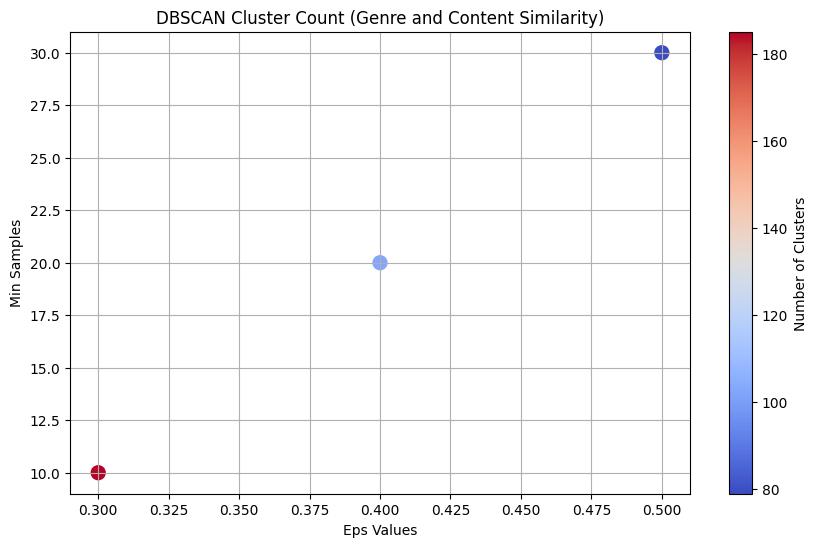

Best DBSCAN for Genre and Content Similarity:
  eps=0.3, min_samples=10
  Number of clusters: 185, Noise points: 4809
  Silhouette Score: 0.7893838388228958

Running DBSCAN tuning for: General Combination
Testing DBSCAN with eps=0.8, min_samples=50...
DBSCAN with eps=0.8, min_samples=50:
  Number of clusters: 53, Noise points: 7415
  Silhouette Score: 0.5712810276688475
Testing DBSCAN with eps=1.0, min_samples=100...
DBSCAN with eps=1.0, min_samples=100:
  Number of clusters: 28, Noise points: 9115
  Silhouette Score: 0.5525126628509218
Testing DBSCAN with eps=1.2, min_samples=150...
DBSCAN with eps=1.2, min_samples=150:
  Number of clusters: 21, Noise points: 9933
  Silhouette Score: 0.5427688023318132
--------------------------------------------------


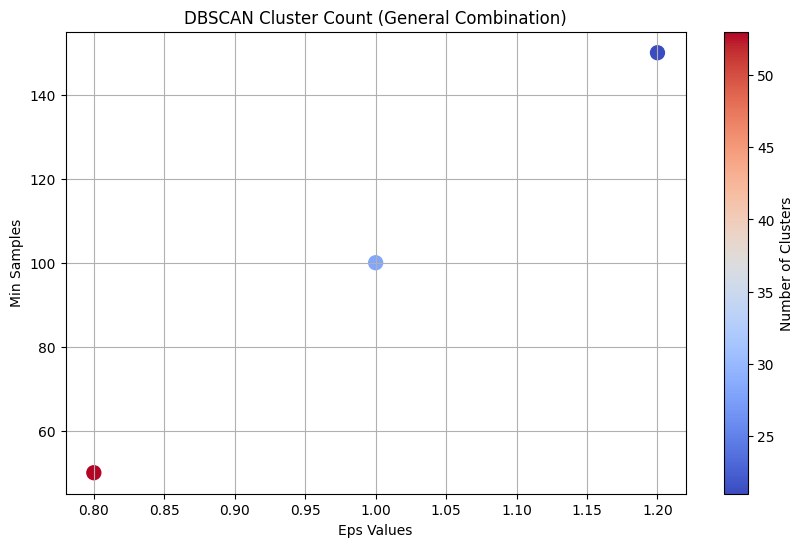

Best DBSCAN for General Combination:
  eps=0.8, min_samples=50
  Number of clusters: 53, Noise points: 7415
  Silhouette Score: 0.5712810276688475

Running DBSCAN tuning for: Temporal and Content Analysis
Testing DBSCAN with eps=0.5, min_samples=20...
DBSCAN with eps=0.5, min_samples=20:
  Number of clusters: 127, Noise points: 8743
  Silhouette Score: 0.6077289690456027
Testing DBSCAN with eps=0.6, min_samples=40...
DBSCAN with eps=0.6, min_samples=40:
  Number of clusters: 74, Noise points: 10254
  Silhouette Score: 0.5793801071535266
Testing DBSCAN with eps=0.7, min_samples=60...
DBSCAN with eps=0.7, min_samples=60:
  Number of clusters: 62, Noise points: 10821
  Silhouette Score: 0.5687997127829311
--------------------------------------------------


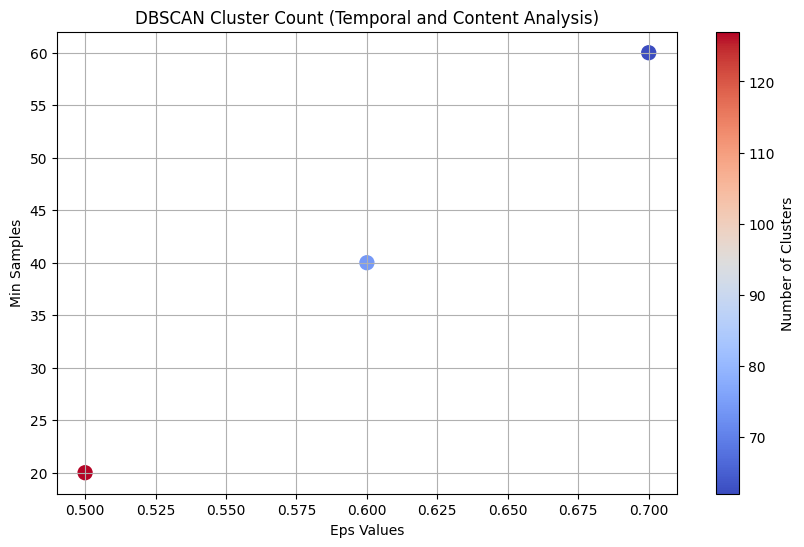

Best DBSCAN for Temporal and Content Analysis:
  eps=0.5, min_samples=20
  Number of clusters: 127, Noise points: 8743
  Silhouette Score: 0.6077289690456027

Running DBSCAN tuning for: Temporal and Commercial Analysis
Testing DBSCAN with eps=0.2, min_samples=10...
DBSCAN with eps=0.2, min_samples=10:
  Number of clusters: 18, Noise points: 153
  Silhouette Score: 0.5266125497196462
Testing DBSCAN with eps=0.3, min_samples=15...
DBSCAN with eps=0.3, min_samples=15:
  Number of clusters: 9, Noise points: 33
  Silhouette Score: 0.6838697062822042
Testing DBSCAN with eps=0.4, min_samples=20...
DBSCAN with eps=0.4, min_samples=20:
  Number of clusters: 5, Noise points: 6
  Silhouette Score: 0.7375194632039832
--------------------------------------------------


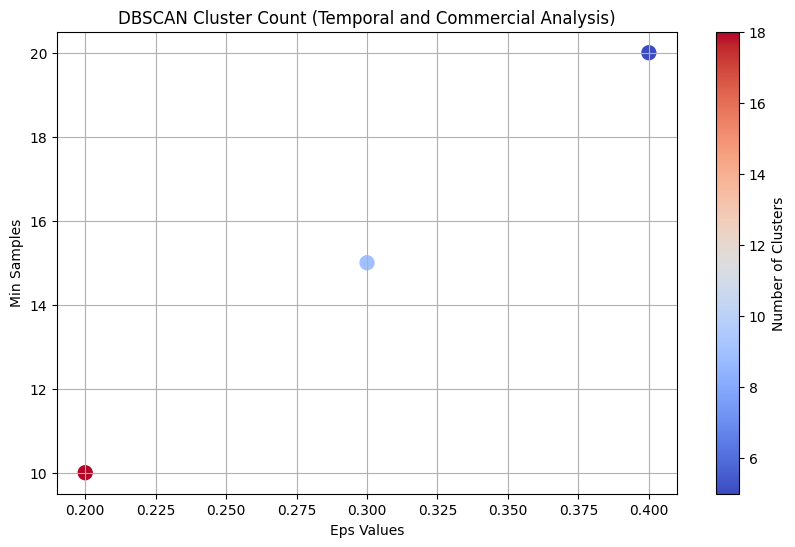

Best DBSCAN for Temporal and Commercial Analysis:
  eps=0.4, min_samples=20
  Number of clusters: 5, Noise points: 6
  Silhouette Score: 0.7375194632039832


In [16]:

dbscan_results_summary = {}

for feature_name, feature_data in feature_sets.items():
    print(f"\nRunning DBSCAN tuning for: {feature_name}")

    params = dbscan_params[feature_name]
    dbscan_results = dbscan_tuning_batch(
        normalized_features=feature_data,
        dbscan_params=params,
        batch_size=1000,
        feature_name=feature_name
    )

    best_dbscan = max(
        (r for r in dbscan_results if r["silhouette_score"] != "Not applicable"),
        key=lambda x: x["silhouette_score"],
        default=None,
    )

    if best_dbscan:
        print(f"Best DBSCAN for {feature_name}:")
        print(f"  eps={best_dbscan['eps']}, min_samples={best_dbscan['min_samples']}")
        print(f"  Number of clusters: {best_dbscan['n_clusters']}, Noise points: {best_dbscan['n_noise']}")
        print(f"  Silhouette Score: {best_dbscan['silhouette_score']}")

        # Store in DataFrame
        cluster_col = f'dbscan_cluster_{feature_name.replace(" ", "_")}'
        df[cluster_col] = best_dbscan['labels']

        # Save results
        dbscan_results_summary[feature_name] = best_dbscan
    else:
        print(f"No suitable DBSCAN clustering found for {feature_name}.")
        dbscan_results_summary[feature_name] = None

--- Final Clustering Results ---

--- KMeans Results ---
Feature Set: Genre and Content Similarity
  Optimal k: 7
  Best Silhouette Score: 0.7374585141110847
  Cluster Distribution: {1: 27258, 6: 12175, 2: 4258, 0: 2422, 5: 2154, 4: 812, 3: 729}



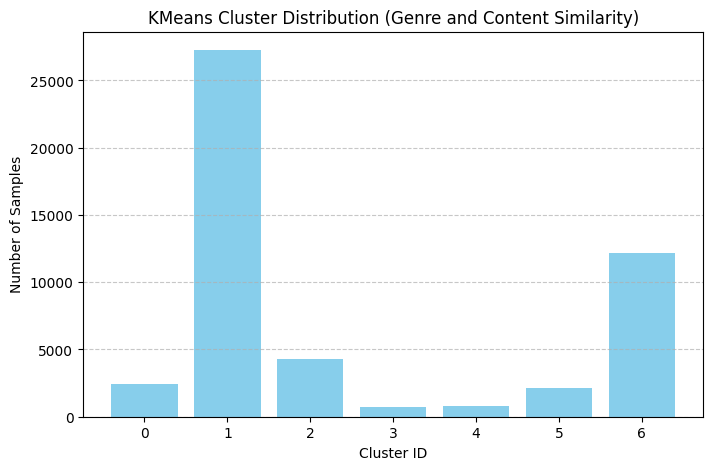

Feature Set: General Combination
  Optimal k: 3
  Best Silhouette Score: 0.6242287157838188
  Cluster Distribution: {1: 27252, 2: 12538, 0: 10018}



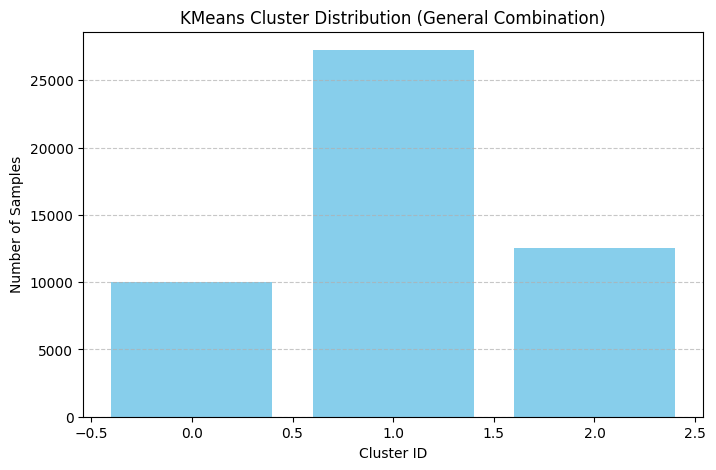

Feature Set: Temporal and Content Analysis
  Optimal k: 8
  Best Silhouette Score: 0.6221271458202972
  Cluster Distribution: {1: 11123, 7: 7375, 3: 5845, 2: 5799, 6: 5164, 5: 5126, 0: 4886, 4: 4490}



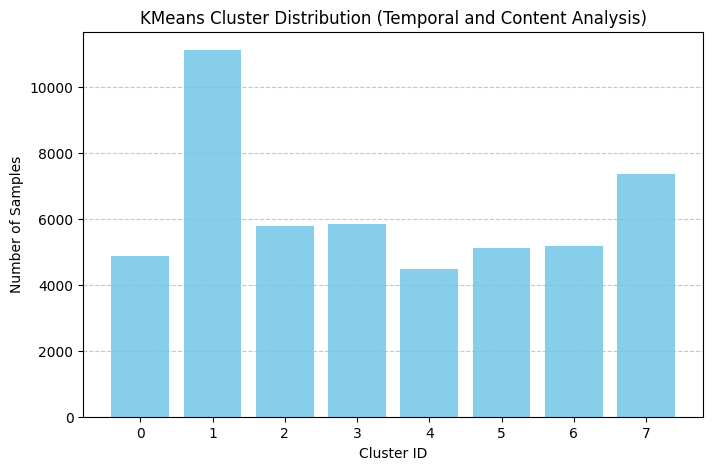

Feature Set: Temporal and Commercial Analysis
  Optimal k: 4
  Best Silhouette Score: 0.7911275260123095
  Cluster Distribution: {1: 18498, 2: 11644, 0: 10012, 3: 9654}



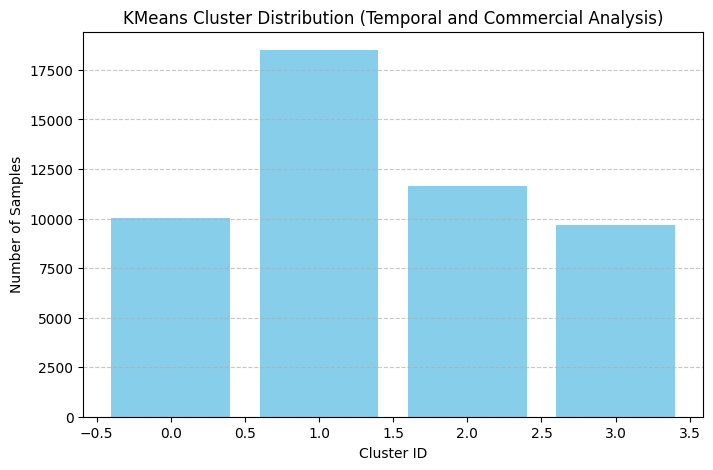

--- DBSCAN Results ---
Feature Set: Genre and Content Similarity
  Best eps: 0.3
  Best min_samples: 10
  Number of clusters: 185
  Noise points: 4809
  Best Silhouette Score: 0.7893838388228958



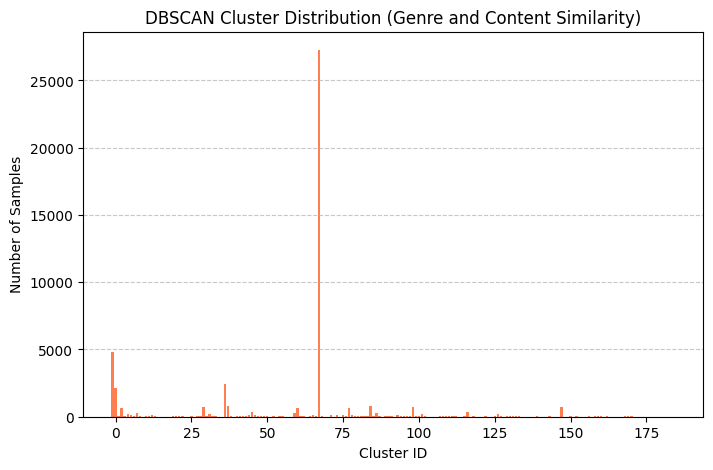

Feature Set: General Combination
  Best eps: 0.8
  Best min_samples: 50
  Number of clusters: 53
  Noise points: 7415
  Best Silhouette Score: 0.5712810276688475



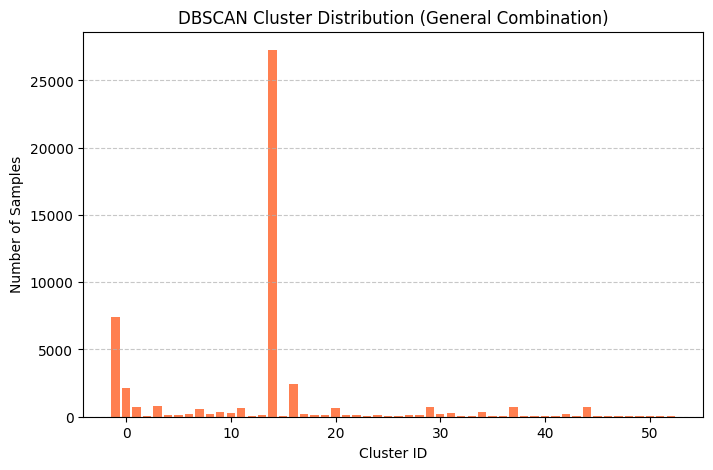

Feature Set: Temporal and Content Analysis
  Best eps: 0.5
  Best min_samples: 20
  Number of clusters: 127
  Noise points: 8743
  Best Silhouette Score: 0.6077289690456027



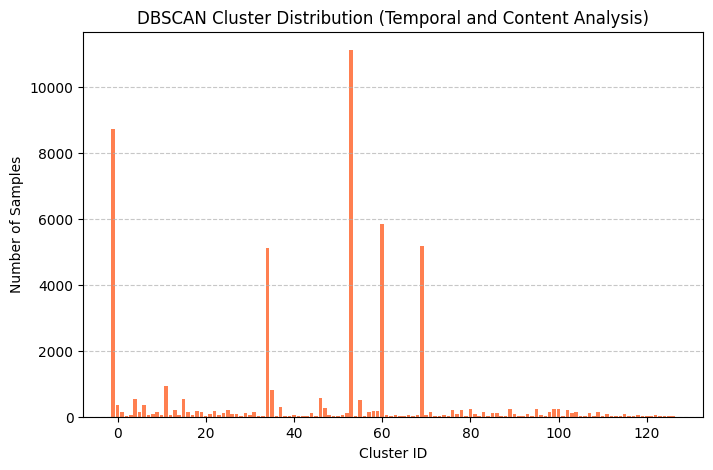

Feature Set: Temporal and Commercial Analysis
  Best eps: 0.4
  Best min_samples: 20
  Number of clusters: 5
  Noise points: 6
  Best Silhouette Score: 0.7375194632039832



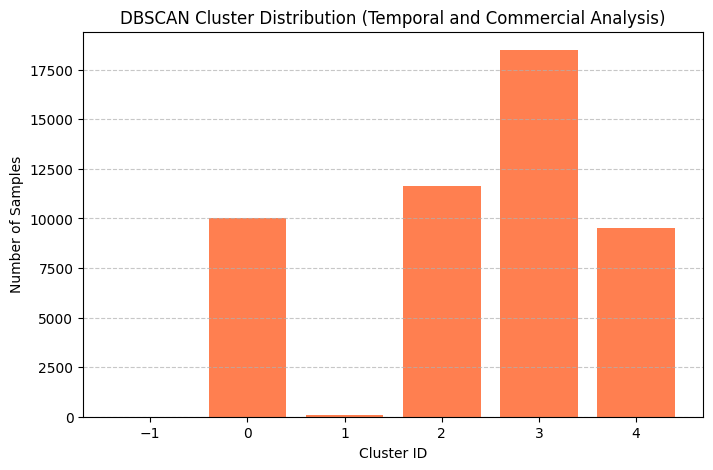

Visualizing DBSCAN Clusters for Feature Set: Genre and Content Similarity


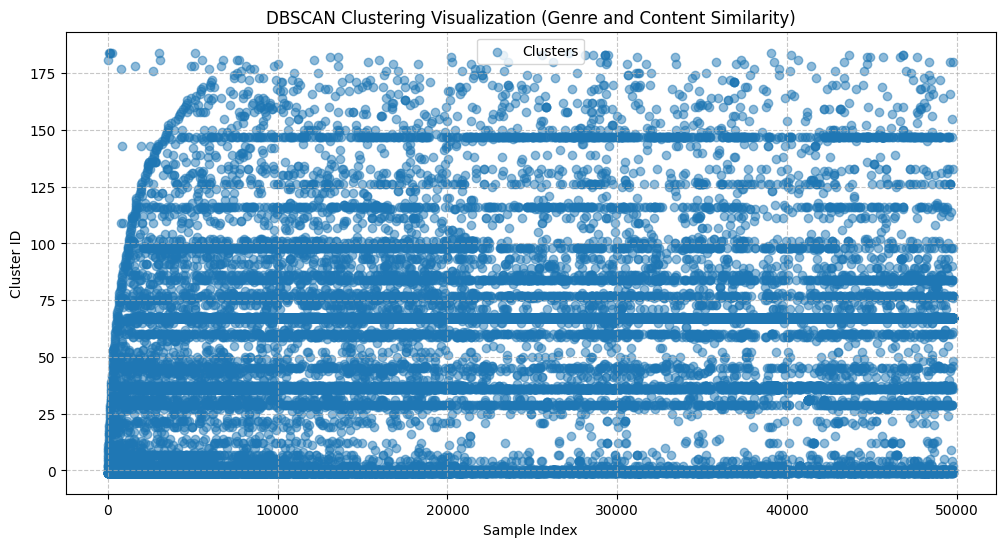

Visualizing DBSCAN Clusters for Feature Set: General Combination


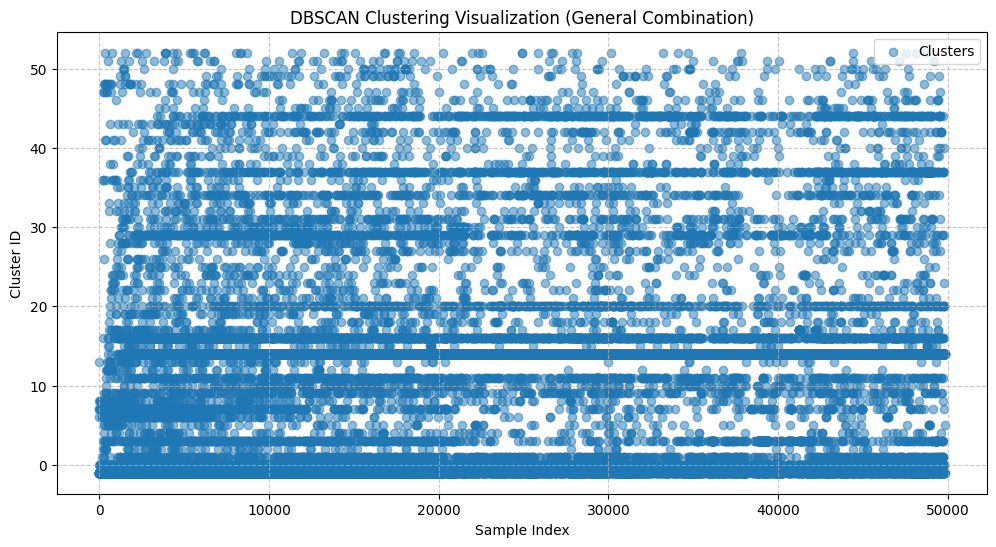

Visualizing DBSCAN Clusters for Feature Set: Temporal and Content Analysis


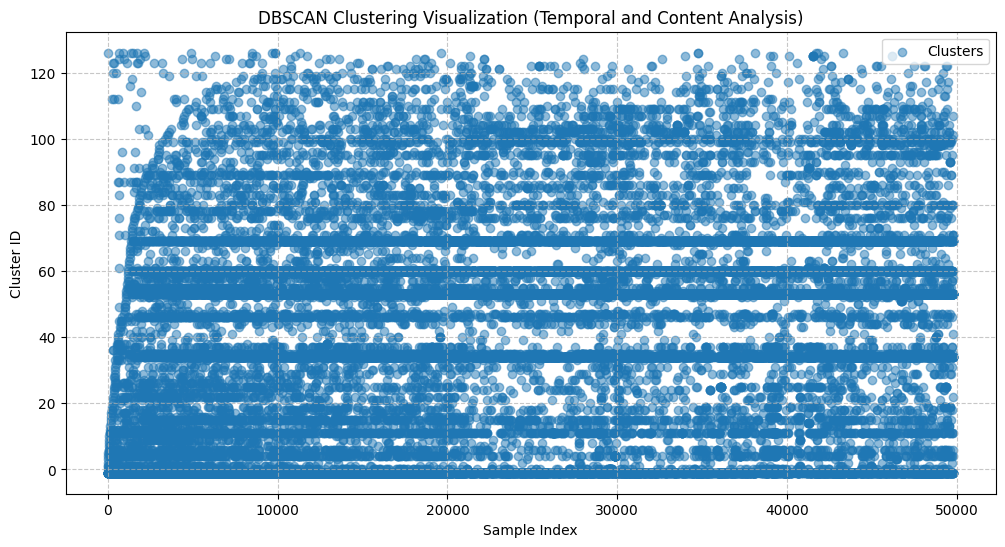

Visualizing DBSCAN Clusters for Feature Set: Temporal and Commercial Analysis


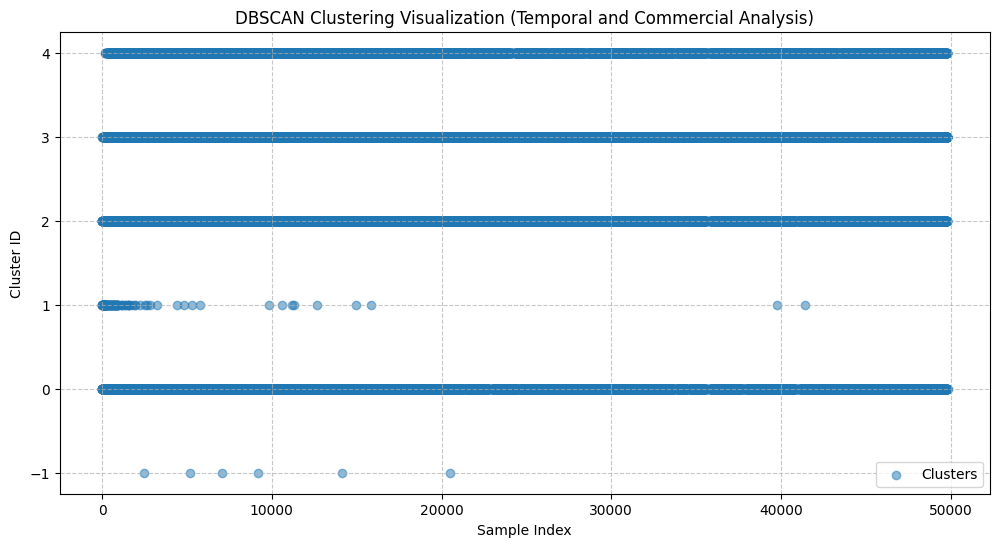

In [17]:
#%% Report Best Results for Clustering

print("--- Final Clustering Results ---\n")

# KMeans Results Summary
if 'kmeans_results' in globals():
    print("--- KMeans Results ---")
    for feature_name, results in kmeans_results.items():
        print(f"Feature Set: {feature_name}")
        print(f"  Optimal k: {results['optimal_k']}")
        print(f"  Best Silhouette Score: {max(results['silhouette_scores']) if results['silhouette_scores'] else 'N/A'}")
        
        cluster_distribution = pd.Series(results["cluster_labels"]).value_counts().to_dict()
        print(f"  Cluster Distribution: {cluster_distribution}\n")

        # Plot KMeans Cluster Distribution
        plt.figure(figsize=(8, 5))
        plt.bar(cluster_distribution.keys(), cluster_distribution.values(), color='skyblue')
        plt.xlabel("Cluster ID")
        plt.ylabel("Number of Samples")
        plt.title(f"KMeans Cluster Distribution ({feature_name})")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
else:
    print("No KMeans results found.\n")
    
    
# DBSCAN Results Summary
if 'dbscan_results_summary' in globals():
    print("--- DBSCAN Results ---")
    for feature_name, result in dbscan_results_summary.items():
        if result:
            print(f"Feature Set: {feature_name}")
            print(f"  Best eps: {result['eps']}")
            print(f"  Best min_samples: {result['min_samples']}")
            print(f"  Number of clusters: {result['n_clusters']}")
            print(f"  Noise points: {result['n_noise']}")
            print(f"  Best Silhouette Score: {result['silhouette_score']}\n")

            # Plot DBSCAN Cluster Distribution
            unique_labels, label_counts = np.unique(result["labels"], return_counts=True)
            plt.figure(figsize=(8, 5))
            plt.bar(unique_labels, label_counts, color='coral')
            plt.xlabel("Cluster ID")
            plt.ylabel("Number of Samples")
            plt.title(f"DBSCAN Cluster Distribution ({feature_name})")
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
        else:
            print(f"Feature Set: {feature_name} - No valid clustering found.\n")
            
#%% Visualizing DBSCAN Clusters
for feature_name, result in dbscan_results_summary.items():
    cluster_col = f'dbscan_cluster_{feature_name.replace(" ", "_")}'
    if cluster_col in df.columns:
        print(f"Visualizing DBSCAN Clusters for Feature Set: {feature_name}")
        plt.figure(figsize=(12, 6))
        plt.scatter(df.index, df[cluster_col], alpha=0.5, label="Clusters")
        plt.title(f"DBSCAN Clustering Visualization ({feature_name})")
        plt.xlabel("Sample Index")
        plt.ylabel("Cluster ID")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.show()
    else:
        print(f"Warning: {cluster_col} not found in DataFrame. Skipping visualization for {feature_name}.")

In [18]:
##%% Analyze Cluster Patterns
print("--- Cluster Patterns Analysis ---\n")

# KMeans Cluster Analysis
if 'kmeans_results' in globals():
    print("--- KMeans Patterns ---")
    for feature_name, results in kmeans_results.items():
        cluster_col = f'kmeans_cluster_{feature_name.replace(" ", "_")}'
        
        if cluster_col in df.columns:
            print(f"\nFeature Set: {feature_name}")
            cluster_labels = df[cluster_col]
            for cluster in np.unique(cluster_labels):
                print(f"Cluster {cluster}:")
                cluster_data = df[df[cluster_col] == cluster]  
                print(cluster_data.describe()) 
        else:
            print(f"Warning: {cluster_col} not found in DataFrame. Skipping {feature_name}.")
else:
    print("No KMeans results found.\n")

# DBSCAN Cluster Analysis
if 'dbscan_results_summary' in globals():
    print("--- DBSCAN Patterns ---")
    for feature_name, results in dbscan_results_summary.items():
        cluster_col = f'dbscan_cluster_{feature_name.replace(" ", "_")}'
        
        if cluster_col in df.columns:
            print(f"\nFeature Set: {feature_name}")
            cluster_labels = df[cluster_col]
            for cluster in np.unique(cluster_labels):
                if cluster == -1:  # Skip noise points
                    print(f"Noise Points: {len(df[df[cluster_col] == -1])}")
                    continue
                print(f"Cluster {cluster}:")
                cluster_data = df[df[cluster_col] == cluster]  
                print(cluster_data.describe()) 
        else:
            print(f"Warning: {cluster_col} not found in DataFrame. Skipping {feature_name}.")
else:
    print("No DBSCAN results found.\n")


--- Cluster Patterns Analysis ---

--- KMeans Patterns ---

Feature Set: Genre and Content Similarity
Cluster 0:
                 id  vote_average   vote_count       revenue      runtime  \
count  2.422000e+03   2422.000000  2422.000000  2.422000e+03  2422.000000   
mean   5.269353e+05      3.580382     5.182134  9.567655e+04    11.830945   
std    3.716442e+05      3.302106     7.754104  2.283445e+06    17.381150   
min    2.751000e+03      0.000000     0.000000  0.000000e+00     0.000000   
25%    2.019878e+05      0.000000     0.000000  0.000000e+00     4.000000   
50%    4.723195e+05      5.000000     1.000000  0.000000e+00     7.000000   
75%    8.348890e+05      6.500000     7.000000  0.000000e+00     9.000000   
max    1.237982e+06     10.000000    31.000000  8.313760e+07    90.000000   

             budget   popularity         Year  original_language_encoded  \
count  2.422000e+03  2422.000000  2422.000000                2422.000000   
mean   2.574964e+04     0.743990  1982.25

Visualizing KMeans Clusters for Feature Set: Genre and Content Similarity


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13796\2828576817.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


ConvexHull error for cluster 0, skipping hull drawing.
ConvexHull error for cluster 1, skipping hull drawing.
ConvexHull error for cluster 3, skipping hull drawing.
ConvexHull error for cluster 4, skipping hull drawing.
ConvexHull error for cluster 5, skipping hull drawing.


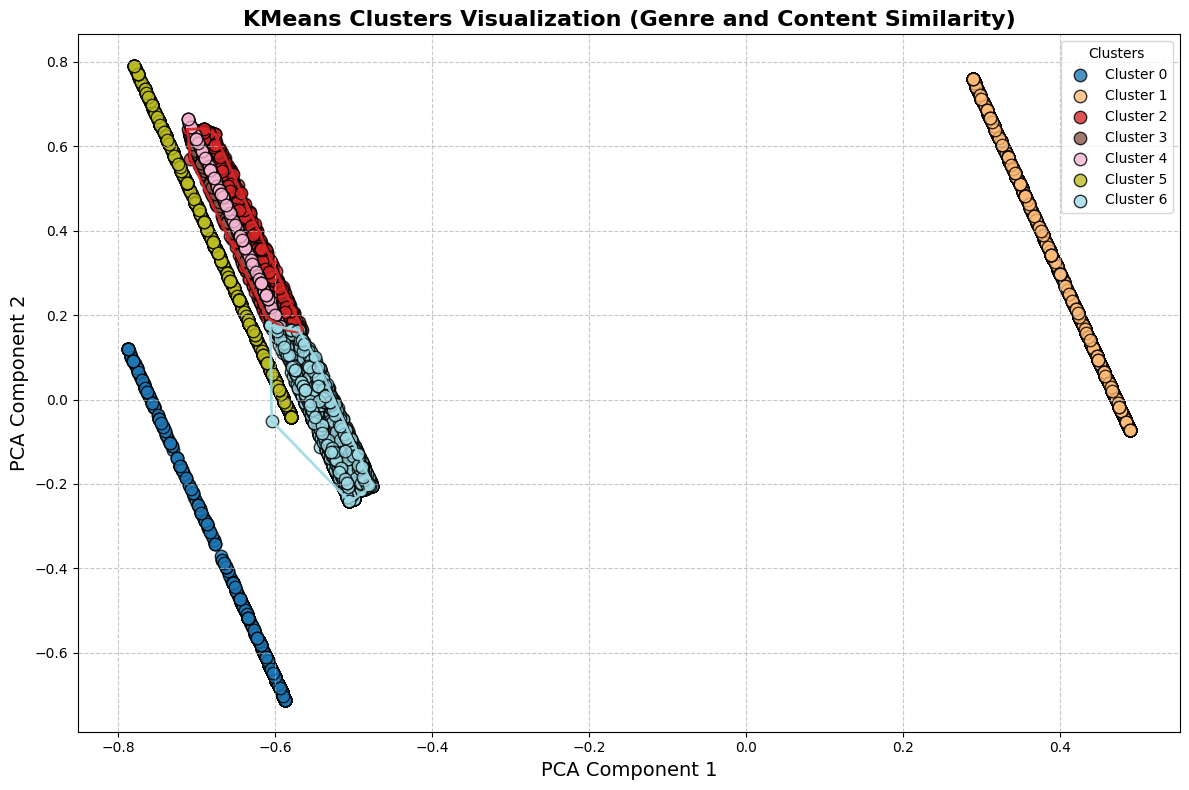

Visualizing KMeans Clusters for Feature Set: General Combination


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13796\2828576817.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


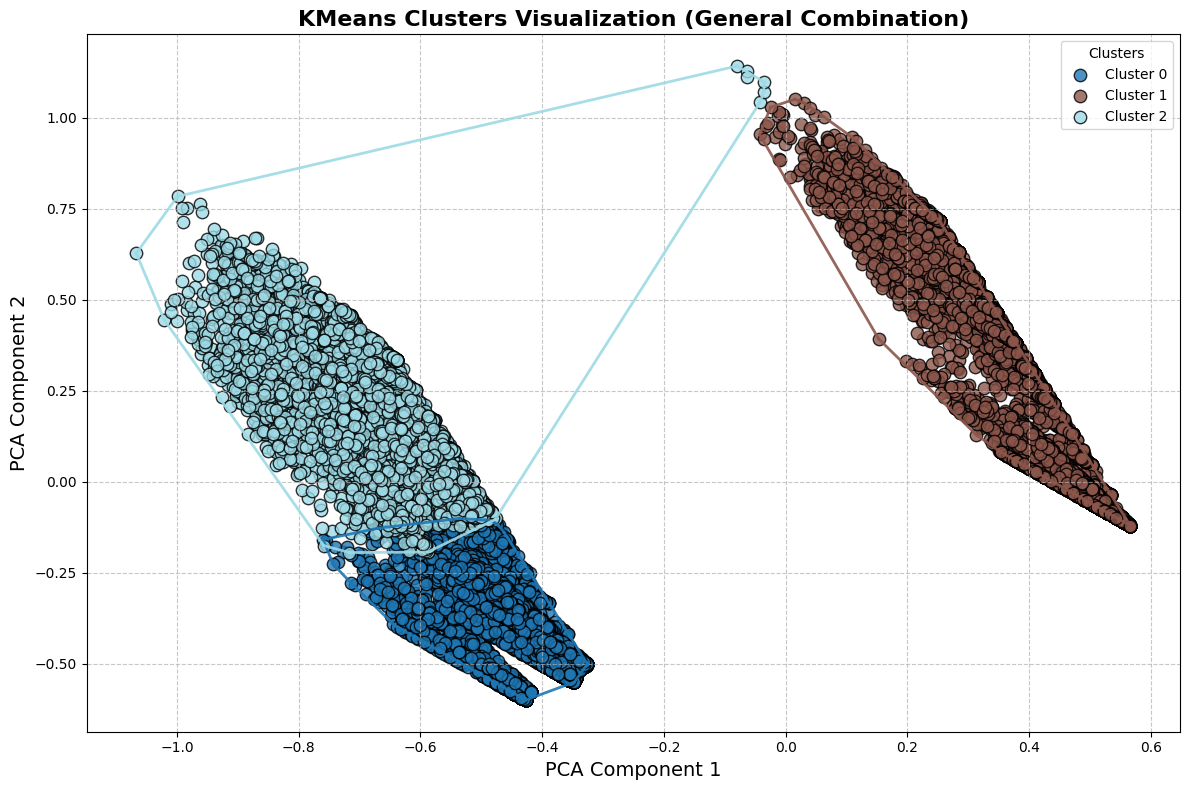

Visualizing KMeans Clusters for Feature Set: Temporal and Content Analysis


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13796\2828576817.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


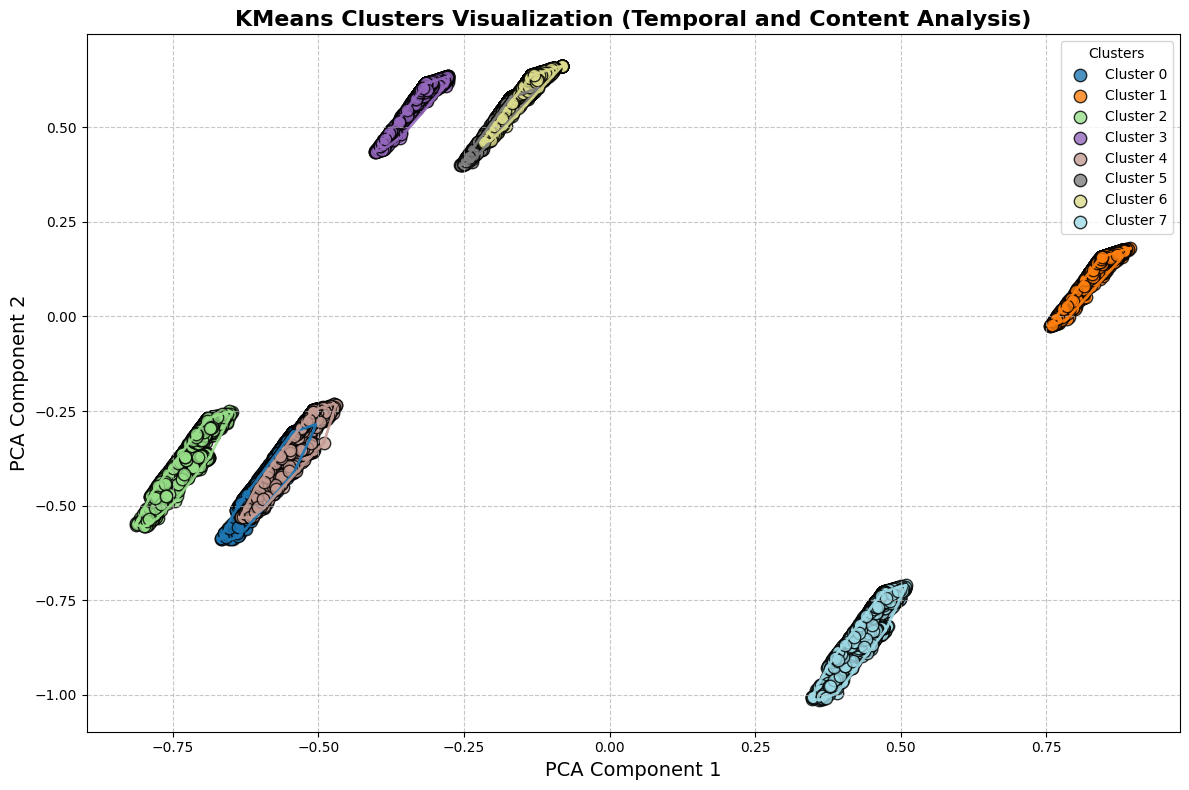

Visualizing KMeans Clusters for Feature Set: Temporal and Commercial Analysis


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13796\2828576817.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


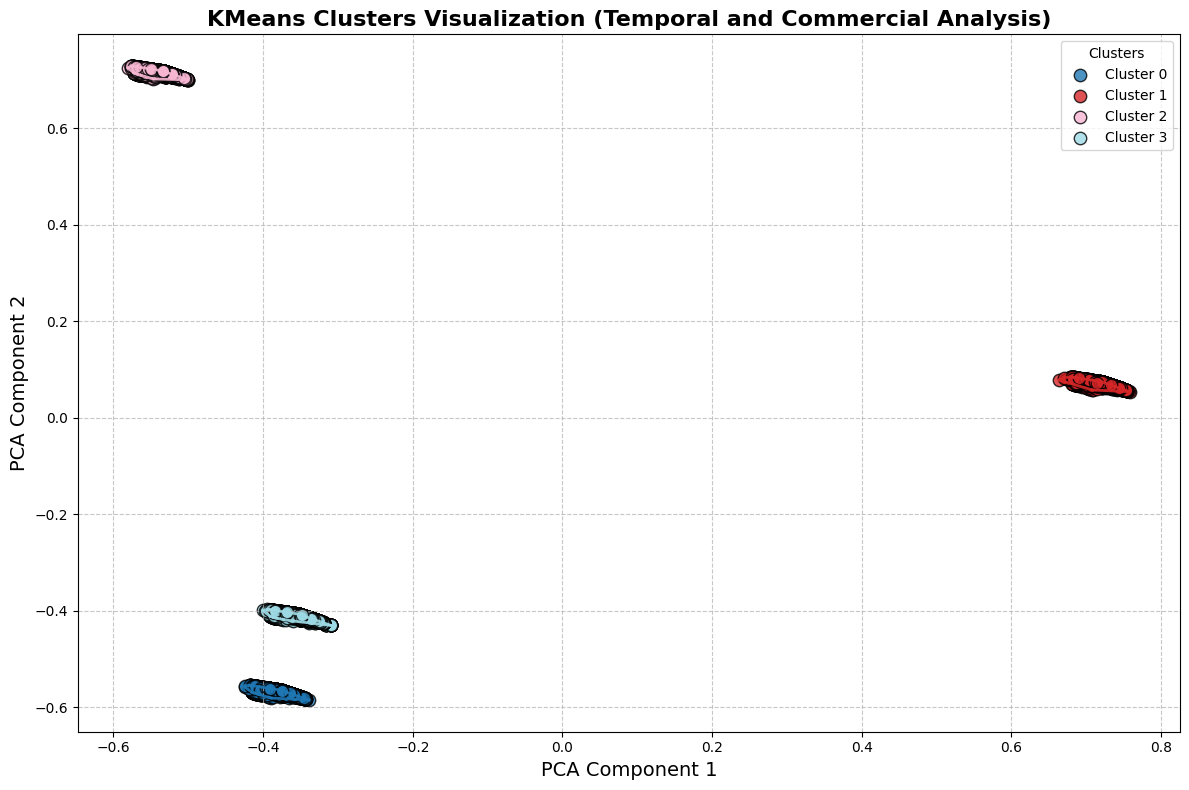

Visualizing DBSCAN Clusters for Feature Set: Genre and Content Similarity


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13796\2828576817.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


ConvexHull error for cluster 0, skipping hull drawing.
ConvexHull error for cluster 1, skipping hull drawing.
ConvexHull error for cluster 2, skipping hull drawing.
ConvexHull error for cluster 3, skipping hull drawing.
ConvexHull error for cluster 4, skipping hull drawing.
ConvexHull error for cluster 5, skipping hull drawing.
ConvexHull error for cluster 6, skipping hull drawing.
ConvexHull error for cluster 7, skipping hull drawing.
ConvexHull error for cluster 8, skipping hull drawing.
ConvexHull error for cluster 9, skipping hull drawing.
ConvexHull error for cluster 10, skipping hull drawing.
ConvexHull error for cluster 11, skipping hull drawing.
ConvexHull error for cluster 12, skipping hull drawing.
ConvexHull error for cluster 13, skipping hull drawing.
ConvexHull error for cluster 14, skipping hull drawing.
ConvexHull error for cluster 15, skipping hull drawing.
ConvexHull error for cluster 16, skipping hull drawing.
ConvexHull error for cluster 17, skipping hull drawing.
Co

C:\Users\Pooria\AppData\Local\Temp\ipykernel_13796\2828576817.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


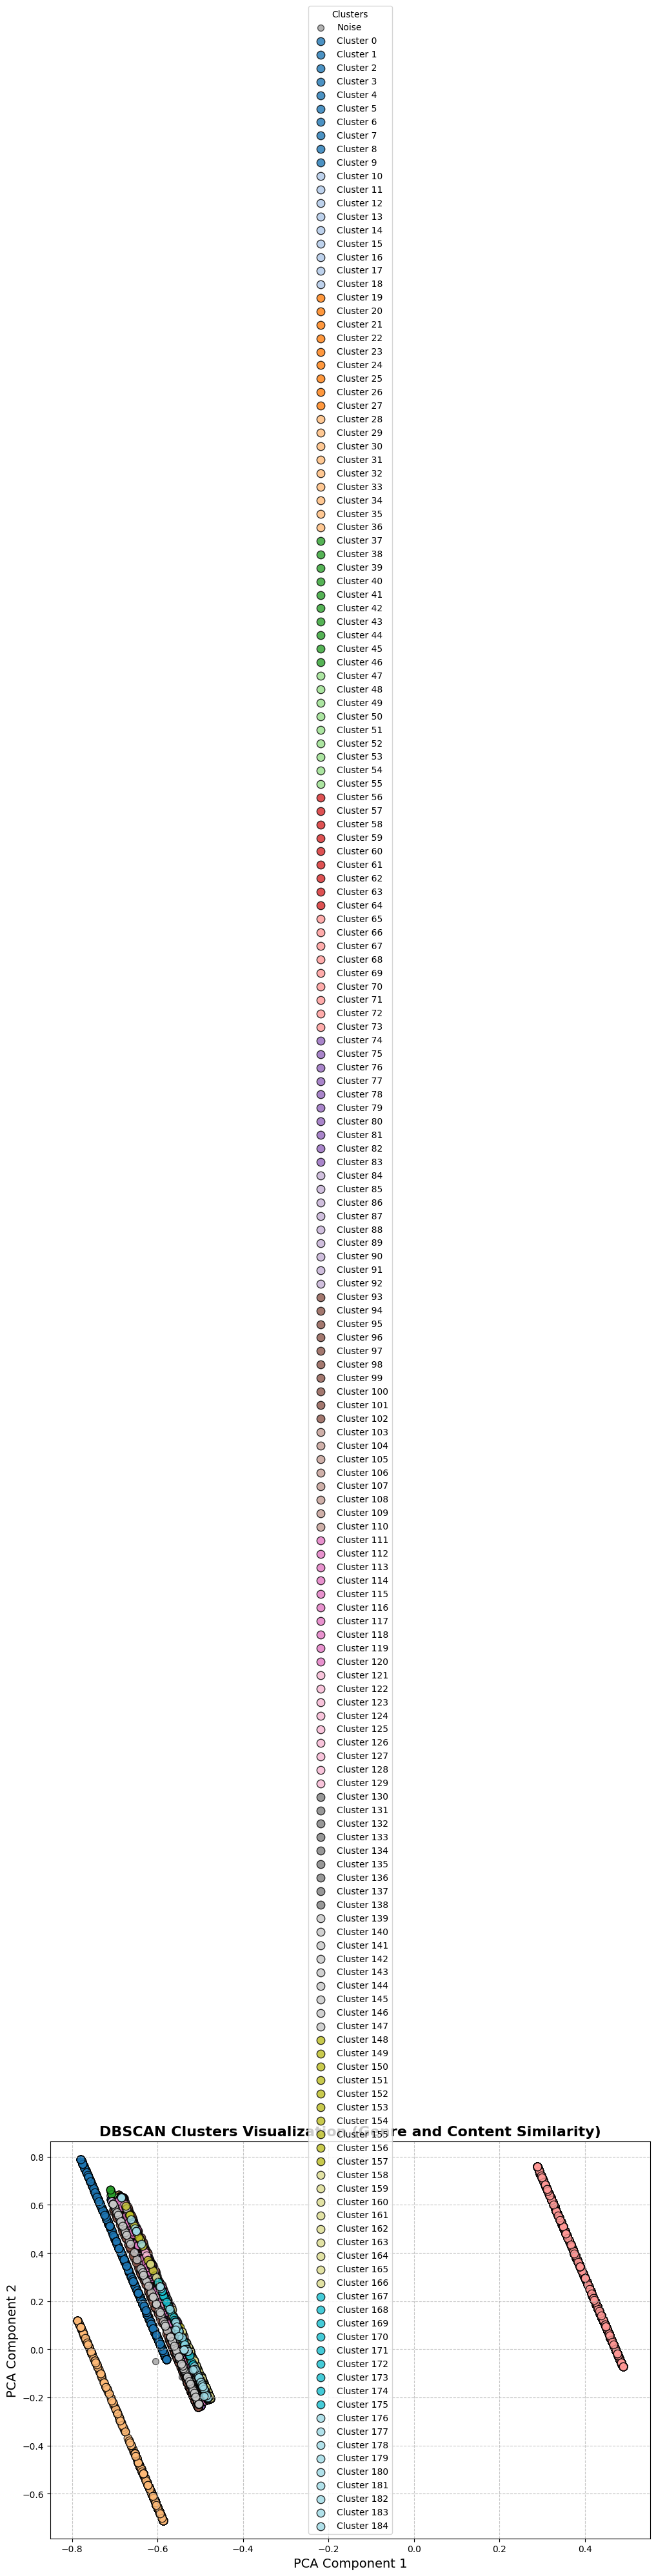

Visualizing DBSCAN Clusters for Feature Set: General Combination


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13796\2828576817.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


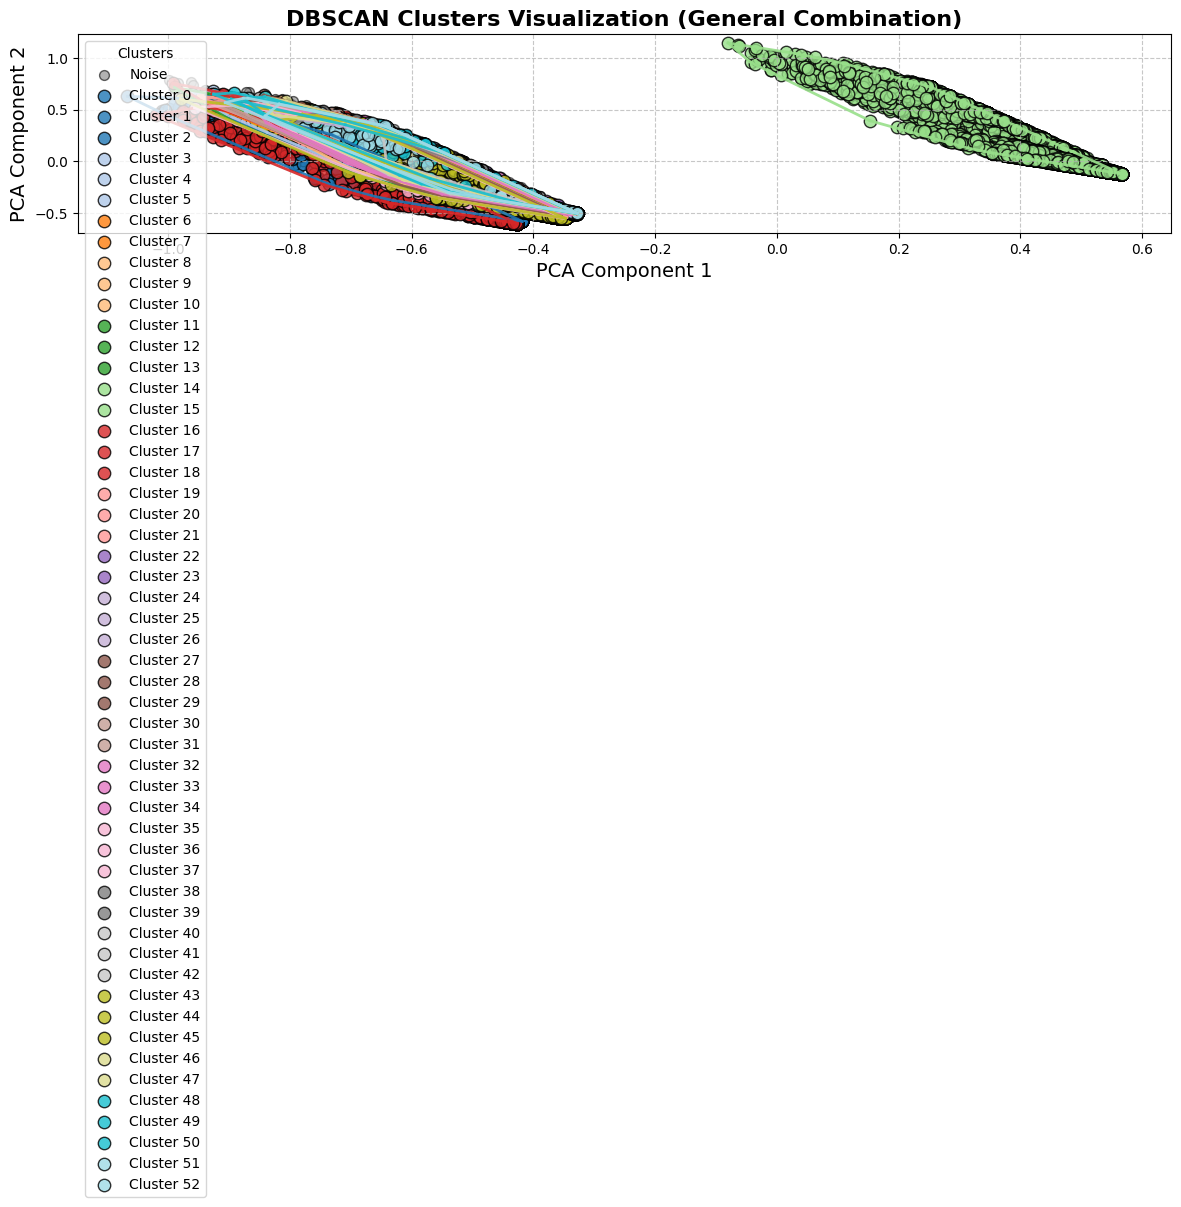

Visualizing DBSCAN Clusters for Feature Set: Temporal and Content Analysis


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13796\2828576817.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap
C:\Users\Pooria\AppData\Local\Temp\ipykernel_13796\2828576817.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


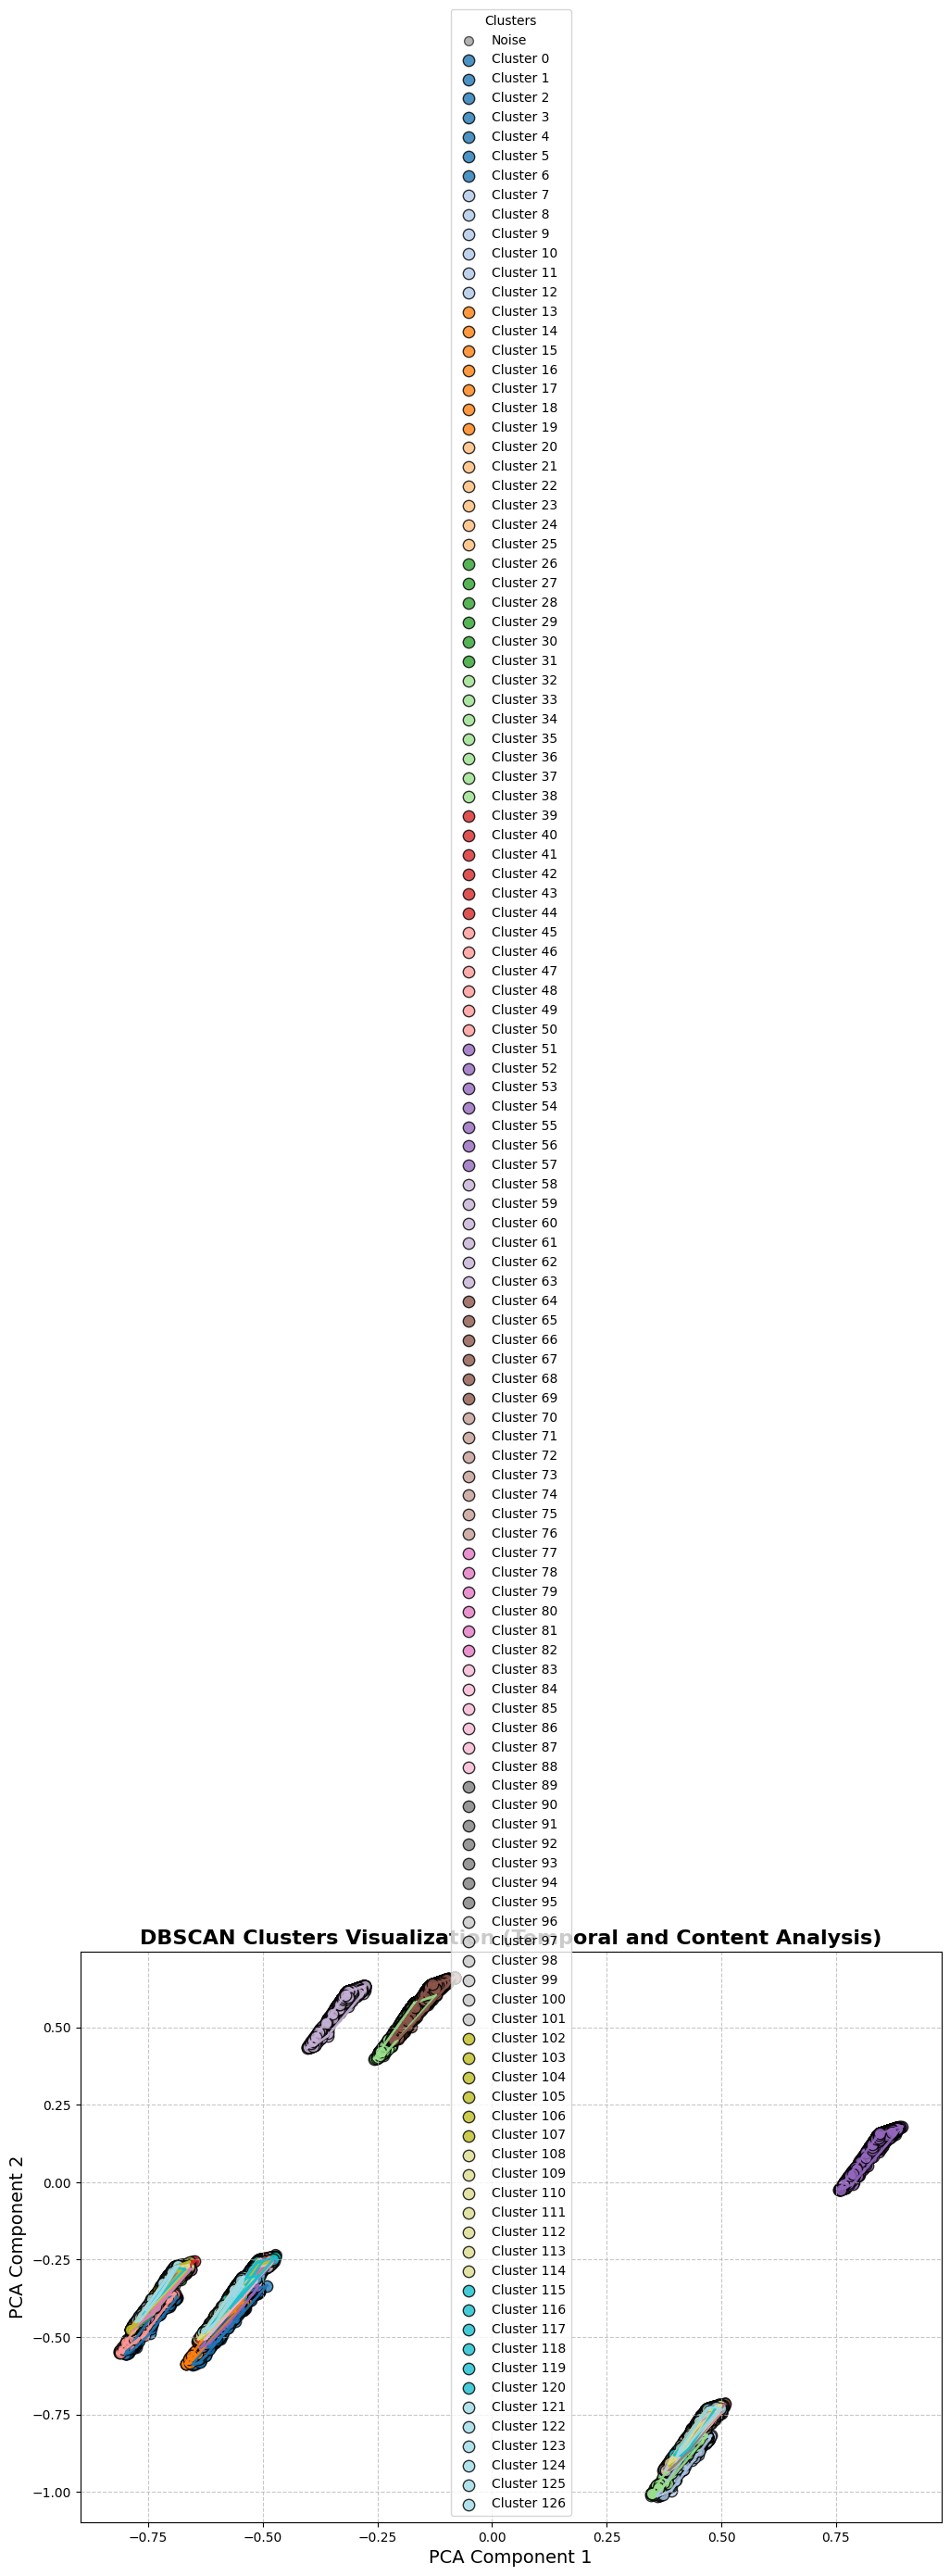

Visualizing DBSCAN Clusters for Feature Set: Temporal and Commercial Analysis


C:\Users\Pooria\AppData\Local\Temp\ipykernel_13796\2828576817.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap


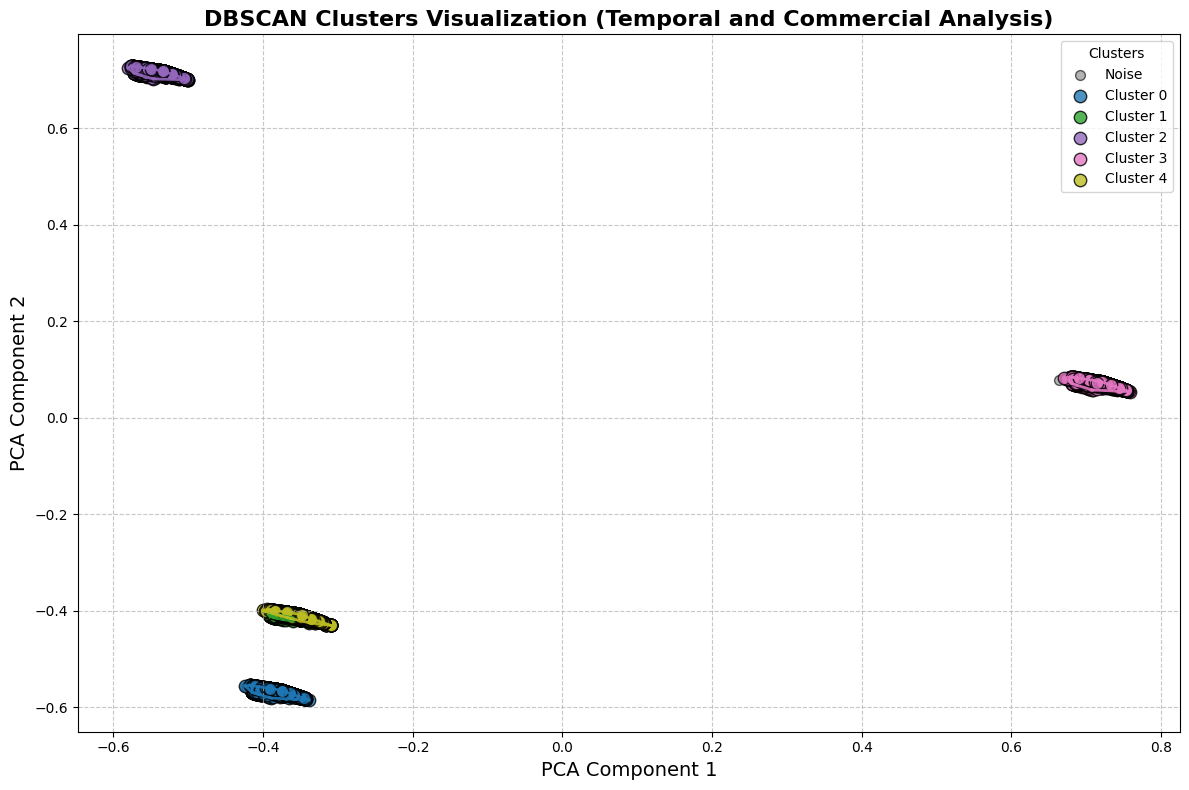

In [19]:
##%% Enhanced Visualization of Clusters with Improved Design

def plot_clusters_with_hulls_improved(data, labels, feature_name, algorithm_name):
    """
    Visualizes clusters using PCA-reduced 2D representation and draws convex hulls where possible.
    Handles noise points separately.
    """
    # Reduce data to 2D using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Improved colormap

    for label in unique_labels:
        if label == -1:
            # Noise points
            plt.scatter(
                reduced_data[labels == label, 0],
                reduced_data[labels == label, 1],
                c="gray",
                s=50,
                label="Noise",
                alpha=0.6,
                edgecolor="k",
            )
        else:
            # Cluster points
            cluster_points = reduced_data[labels == label]
            plt.scatter(
                cluster_points[:, 0],
                cluster_points[:, 1],
                color=colors(label / len(unique_labels)),
                s=80,
                label=f"Cluster {label}",
                alpha=0.8,
                edgecolor="k",
            )

            # Draw convex hull around the cluster (only if enough points exist)
            if len(cluster_points) > 3:  # ConvexHull needs at least 4 points
                try:
                    hull = ConvexHull(cluster_points)
                    for simplex in hull.simplices:
                        plt.plot(
                            cluster_points[simplex, 0],
                            cluster_points[simplex, 1],
                            c=colors(label / len(unique_labels)),
                            lw=2,
                            alpha=0.9,
                        )
                except QhullError:
                    print(f"ConvexHull error for cluster {label}, skipping hull drawing.")

    # Enhance plot aesthetics
    plt.title(
        f"{algorithm_name} Clusters Visualization ({feature_name})",
        fontsize=16,
        fontweight="bold",
    )
    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    plt.legend(title="Clusters", loc="best", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# Visualize KMeans Clusters
if 'kmeans_results' in globals():
    for feature_name, results in kmeans_results.items():
        cluster_col = f'kmeans_cluster_{feature_name.replace(" ", "_")}'
        
        if cluster_col in df.columns:
            print(f"Visualizing KMeans Clusters for Feature Set: {feature_name}")
            cluster_labels = df[cluster_col]
            plot_clusters_with_hulls_improved(
                data=feature_sets[feature_name],
                labels=cluster_labels,
                feature_name=feature_name,
                algorithm_name="KMeans",
            )
        else:
            print(f"Warning: {cluster_col} not found in DataFrame. Skipping visualization for {feature_name}.")
else:
    print("No KMeans results found.\n")

# Visualize DBSCAN Clusters
if 'dbscan_results_summary' in globals():
    for feature_name, results in dbscan_results_summary.items():
        cluster_col = f'dbscan_cluster_{feature_name.replace(" ", "_")}'
        
        if feature_name in dbscan_results_summary and "labels" in dbscan_results_summary[feature_name]:
            print(f"Visualizing DBSCAN Clusters for Feature Set: {feature_name}")
            cluster_labels = dbscan_results_summary[feature_name]["labels"]
            plot_clusters_with_hulls_improved(
                data=feature_sets[feature_name],
                labels=cluster_labels,
                feature_name=feature_name,
                algorithm_name="DBSCAN",
            )
        else:
            print(f"Warning: Clustering results not found for {feature_name}. Skipping visualization.")
else:
    print("No DBSCAN results found.\n")


# Classification

In [15]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter


In [16]:
# Select relevant features
selected_features = [
    'budget', 'revenue', 'vote_average', 'vote_count', 'runtime',
    'popularity_normalized', 'runtime_normalized', 'vote_average_normalized',
    'budget_normalized', 'revenue_normalized', 'ROI', 'content_complexity',
    'genre_similarity_score', 'production_companies_encoded', 'original_language_encoded'
]

# Create the target column `is_popular`
df['is_popular'] = (df['popularity_normalized'] > 0.75).astype(int)

In [17]:
# Define features (X) and target (y)
X = df[selected_features]
y = df['is_popular']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Display the shape of train and test sets
print(f"Train set size after SMOTE: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Train set size after SMOTE: 77794 samples
Test set size: 9962 samples


In [18]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models with balanced class weights (where applicable)
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "SVM": SVC(random_state=42, class_weight="balanced", probability=True),
    "Naive Bayes": GaussianNB()
}

# Train models and calculate train accuracy
train_accuracies = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_scaled, y_train) if model_name != "Naive Bayes" else model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train_scaled) if model_name != "Naive Bayes" else model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies[model_name] = train_accuracy
    print(f"{model_name} Train Accuracy: {train_accuracy:.4f}")

# Display training accuracies
print("\nTraining Accuracies:")
for model_name, accuracy in train_accuracies.items():
    print(f"{model_name}: {accuracy:.4f}")


Training Decision Tree...
Decision Tree Train Accuracy: 1.0000

Training SVM...
SVM Train Accuracy: 0.9962

Training Naive Bayes...
Naive Bayes Train Accuracy: 0.5077

Training Accuracies:
Decision Tree: 1.0000
SVM: 0.9962
Naive Bayes: 0.5077


In [19]:
# Decision Tree Hyperparameter Tuning
print("\nTuning Decision Tree...")
dt_param_grid = {
    "max_depth": [5, 10, 15],  # Restrict tree depth
    "min_samples_split": [10, 20, 50],  # Larger splits for stability
    "min_samples_leaf": [5, 10, 20],  # Ensure minimum samples per leaf
    "ccp_alpha": [0.0, 0.01, 0.1]  # Cost-complexity pruning
}
dt_grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=dt_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
dt_grid_search.fit(X_train_scaled, y_train)
best_dt = dt_grid_search.best_estimator_
print("Best Decision Tree Parameters:", dt_grid_search.best_params_)

# SVM Hyperparameter Tuning
print("\nTuning SVM...")

# Quick SVM Hyperparameter Tuning
print("\nQuick Tuning SVM...")
quick_svm_param_grid = {
    "C": [1, 10],  # Limited range for regularization parameter
    "kernel": ["linear"]  # Focus on the linear kernel for simplicity
}
quick_svm_grid_search = GridSearchCV(
    SVC(random_state=42, class_weight="balanced", probability=True),
    param_grid=quick_svm_param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)
quick_svm_grid_search.fit(X_train_scaled, y_train)
best_quick_svm = quick_svm_grid_search.best_estimator_
print("Quick Tuning SVM Parameters:", quick_svm_grid_search.best_params_)

# Detailed SVM Hyperparameter Tuning (Commented for slower execution)
# Uncomment this section if detailed tuning is required
# print("\nDetailed Tuning SVM...")
# detailed_svm_param_grid = {
#     "C": [0.1, 1, 10],  # Wider range for regularization parameter
#     "kernel": ["linear", "rbf"],  # Explore both linear and RBF kernels
#     "gamma": [0.001, 0.01, 0.1, 1]  # Tuning gamma for RBF kernel
# }
# detailed_svm_grid_search = GridSearchCV(
#     SVC(random_state=42, class_weight="balanced", probability=True),
#     param_grid=detailed_svm_param_grid,
#     cv=5,
#     scoring="accuracy",
#     n_jobs=-1
# )
# detailed_svm_grid_search.fit(X_train_scaled, y_train)
# best_detailed_svm = detailed_svm_grid_search.best_estimator_
# print("Detailed Tuning SVM Parameters:", detailed_svm_grid_search.best_params_)

# Select the best SVM model based on the required mode
best_svm = best_quick_svm  # Use the quick version by default
# best_svm = best_detailed_svm  # Uncomment to use the detailed version

# Naive Bayes Hyperparameter Tuning
print("\nTuning Naive Bayes...")
nb_param_grid = {
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}
nb_grid_search = GridSearchCV(
    GaussianNB(),
    param_grid=nb_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
nb_grid_search.fit(X_train, y_train)
best_nb = nb_grid_search.best_estimator_
print("Best Naive Bayes Parameters:", nb_grid_search.best_params_)

# Save tuned models
tuned_models = {
    "Decision Tree": best_dt,
    "SVM (Quick)": best_quick_svm,
    # "SVM (Detailed)": best_detailed_svm,  # Uncomment if detailed version is used
    "Naive Bayes": best_nb,
}

# Evaluate tuned models on the training set
print("\nEvaluating Tuned Models on Train Set:")
for model_name, model in tuned_models.items():
    if "Naive Bayes" in model_name:
        # Use unscaled features for Naive Bayes
        train_accuracy = model.score(X_train, y_train)
    else:
        # Use scaled features for Decision Tree and SVM
        train_accuracy = model.score(X_train_scaled, y_train)
    print(f"{model_name} Train Accuracy: {train_accuracy:.4f}")


Tuning Decision Tree...
Best Decision Tree Parameters: {'ccp_alpha': 0.0, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}

Tuning SVM...

Quick Tuning SVM...
Quick Tuning SVM Parameters: {'C': 10, 'kernel': 'linear'}

Tuning Naive Bayes...
Best Naive Bayes Parameters: {'var_smoothing': 1e-09}

Evaluating Tuned Models on Train Set:
Decision Tree Train Accuracy: 1.0000
SVM (Quick) Train Accuracy: 0.9994
Naive Bayes Train Accuracy: 0.5077


In [20]:
# # Decision Tree Hyperparameter Tuning
# print("\nTuning Decision Tree...")
# dt_param_grid = {
#     "max_depth": [5, 10, 15, 20, None],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 5],
# }
# dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5, scoring="accuracy", n_jobs=-1)
# dt_grid_search.fit(X_train_scaled, y_train)  # Scaled features for Decision Tree
# best_dt = dt_grid_search.best_estimator_
# print("Best Decision Tree Parameters:", dt_grid_search.best_params_)

# # SVM Hyperparameter Tuning
# print("\nTuning SVM...")
# # Quick SVM Hyperparameter Tuning
# print("\nQuick Tuning SVM...")
# quick_svm_param_grid = {
#     "C": [1, 10],  # Fewer values for `C`
#     "kernel": ["linear"],  # Only `linear` kernel for speed
# }
# quick_svm_grid_search = GridSearchCV(SVC(random_state=42), quick_svm_param_grid, cv=3, scoring="accuracy", n_jobs=-1)
# quick_svm_grid_search.fit(X_train_scaled, y_train)  # Scaled features for SVM
# best_quick_svm = quick_svm_grid_search.best_estimator_
# print("Quick Tuning SVM Parameters:", quick_svm_grid_search.best_params_)

# # Detailed SVM Hyperparameter Tuning (Commented for slower execution)
# # print("\nDetailed Tuning SVM...")
# # detailed_svm_param_grid = {
# #     "C": [0.1, 1, 10],  # Wider range of `C`
# #     "kernel": ["linear", "rbf"],  # Multiple kernels
# #     "gamma": [0.001, 0.01, 0.1, 1],  # Additional gamma values for RBF kernel
# # }
# # detailed_svm_grid_search = GridSearchCV(SVC(random_state=42), detailed_svm_param_grid, cv=5, scoring="accuracy", n_jobs=-1)
# # detailed_svm_grid_search.fit(X_train_scaled, y_train)  # Scaled features for SVM
# # best_detailed_svm = detailed_svm_grid_search.best_estimator_
# # print("Detailed Tuning SVM Parameters:", detailed_svm_grid_search.best_params_)

# # Select best SVM based on the mode
# best_svm = best_quick_svm  # Use the quick version
# # best_svm = best_detailed_svm  # Uncomment to use the detailed version

# # Naive Bayes Hyperparameter Tuning
# print("\nTuning Naive Bayes...")
# nb_param_grid = {
#     "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],  # Wider range for stability
# }
# nb_grid_search = GridSearchCV(GaussianNB(), nb_param_grid, cv=5, scoring="accuracy", n_jobs=-1)

# # Fit with unscaled data (Naive Bayes does not require scaling)
# nb_grid_search.fit(X_train, y_train)
# best_nb = nb_grid_search.best_estimator_
# print("Best Naive Bayes Parameters:", nb_grid_search.best_params_)

# # Save tuned models
# tuned_models = {
#     "Decision Tree": best_dt,
#     "SVM": best_svm,
#     "Naive Bayes": best_nb,
# }

# # Evaluate tuned models on train set
# print("\nEvaluating Tuned Models on Train Set:")
# for model_name, model in tuned_models.items():
#     if model_name == "Naive Bayes":
#         # Use unscaled features for Naive Bayes
#         train_accuracy = model.score(X_train, y_train)
#     else:
#         # Use scaled features for other models
#         train_accuracy = model.score(X_train_scaled, y_train)
#     print(f"{model_name} Train Accuracy: {train_accuracy:.4f}")


In [21]:
def evaluate_model(model, X_test, y_test, model_name, threshold=0.5, scaled_data=None):
    print(f"\nEvaluating {model_name} on Test Set...")

    # Use scaled or unscaled test data
    X_test_data = scaled_data if scaled_data is not None else X_test

    # Predict probabilities for positive class (for SVM and Naive Bayes)
    if model_name in ["SVM", "Naive Bayes"]:
        y_prob = model.predict_proba(X_test_data)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test_data)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)

    # Print metrics
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}

# Evaluate Decision Tree
dt_test_results = evaluate_model(best_dt, X_test, y_test, "Decision Tree", scaled_data=X_test_scaled)

# Evaluate SVM
svm_test_results = evaluate_model(best_svm, X_test, y_test, "SVM", scaled_data=X_test_scaled)

# Evaluate Naive Bayes
nb_test_results = evaluate_model(best_nb, X_test, y_test, "Naive Bayes", scaled_data=None)

# Summarize results
test_results = {
    "Decision Tree": dt_test_results,
    "SVM": svm_test_results,
    "Naive Bayes": nb_test_results,
}

print("\n--- Summary of Test Results ---")
for model_name, metrics in test_results.items():
    print(f"\nModel: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")



Evaluating Decision Tree on Test Set...
Decision Tree Test Accuracy: 1.0000
Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000

Evaluating SVM on Test Set...
SVM Test Accuracy: 0.9991
Precision: 0.9634, Recall: 1.0000, F1-Score: 0.9814

Evaluating Naive Bayes on Test Set...
Naive Bayes Test Accuracy: 0.0433
Precision: 0.0242, Recall: 0.9958, F1-Score: 0.0472

--- Summary of Test Results ---

Model: Decision Tree
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Model: SVM
Accuracy: 0.9991
Precision: 0.9634
Recall: 1.0000
F1-Score: 0.9814

Model: Naive Bayes
Accuracy: 0.0433
Precision: 0.0242
Recall: 0.9958
F1-Score: 0.0472



Analyzing Feature Importance from Decision Tree...


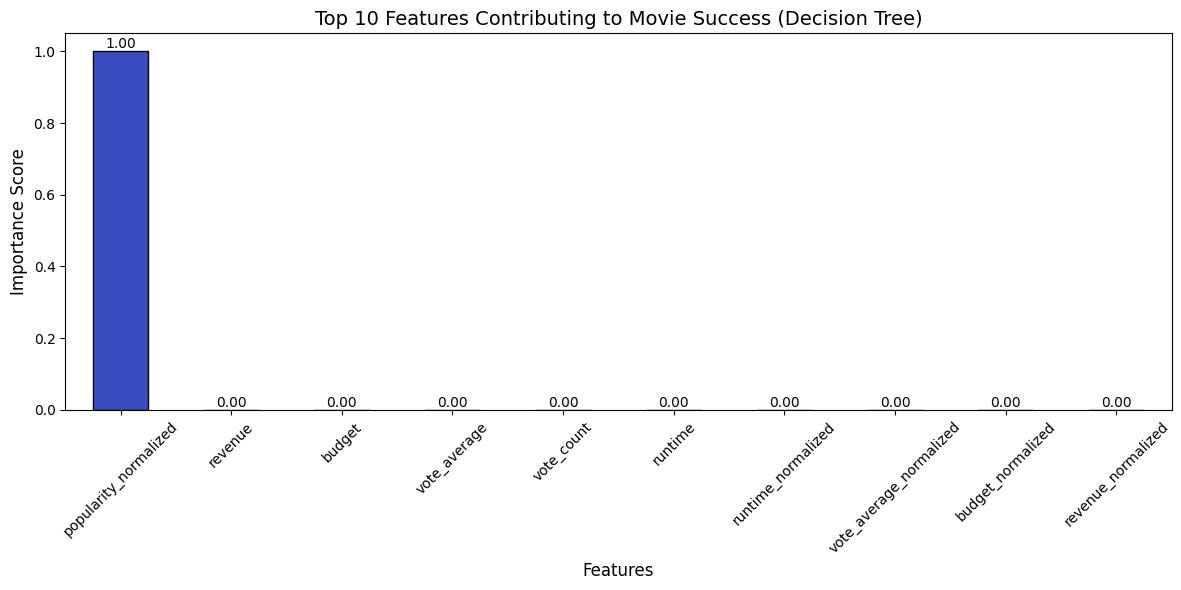


Analyzing Feature Importance from SVM (Linear Kernel)...


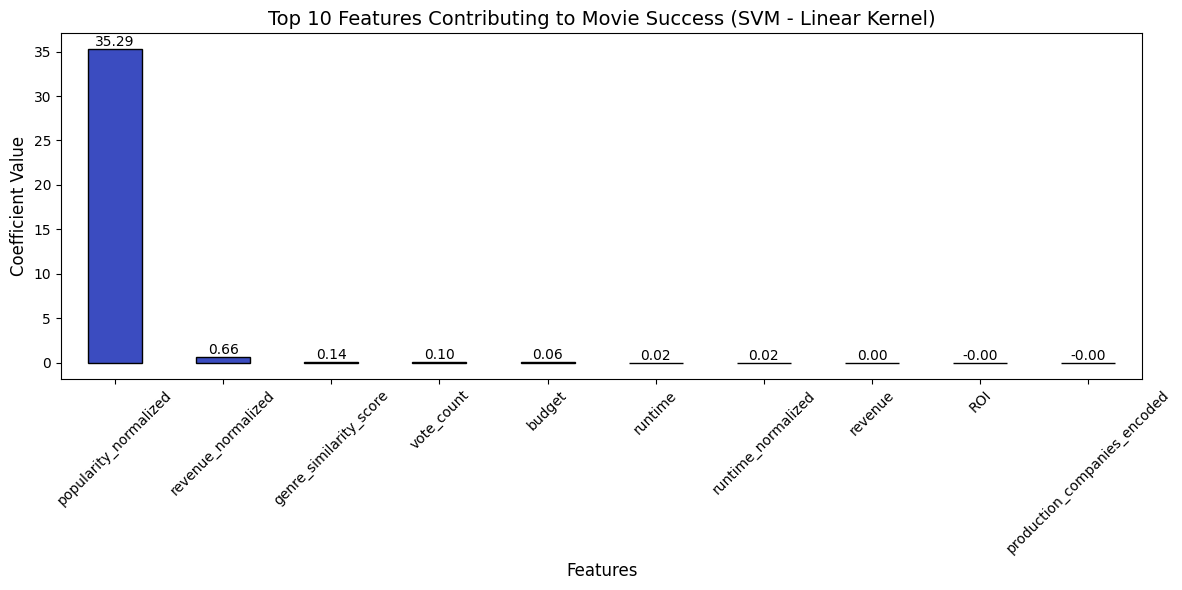


Analyzing Predictions from Naive Bayes...


C:\Users\Pooria\AppData\Local\Temp\ipykernel_24772\1565139765.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Pooria\AppData\Local\Temp\ipykernel_24772\1565139765.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Pooria\AppData\Local\Temp\ipykernel_24772\1565139765.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Pooria\AppData\Local\Temp\ipykernel_24772\1565139765.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable t

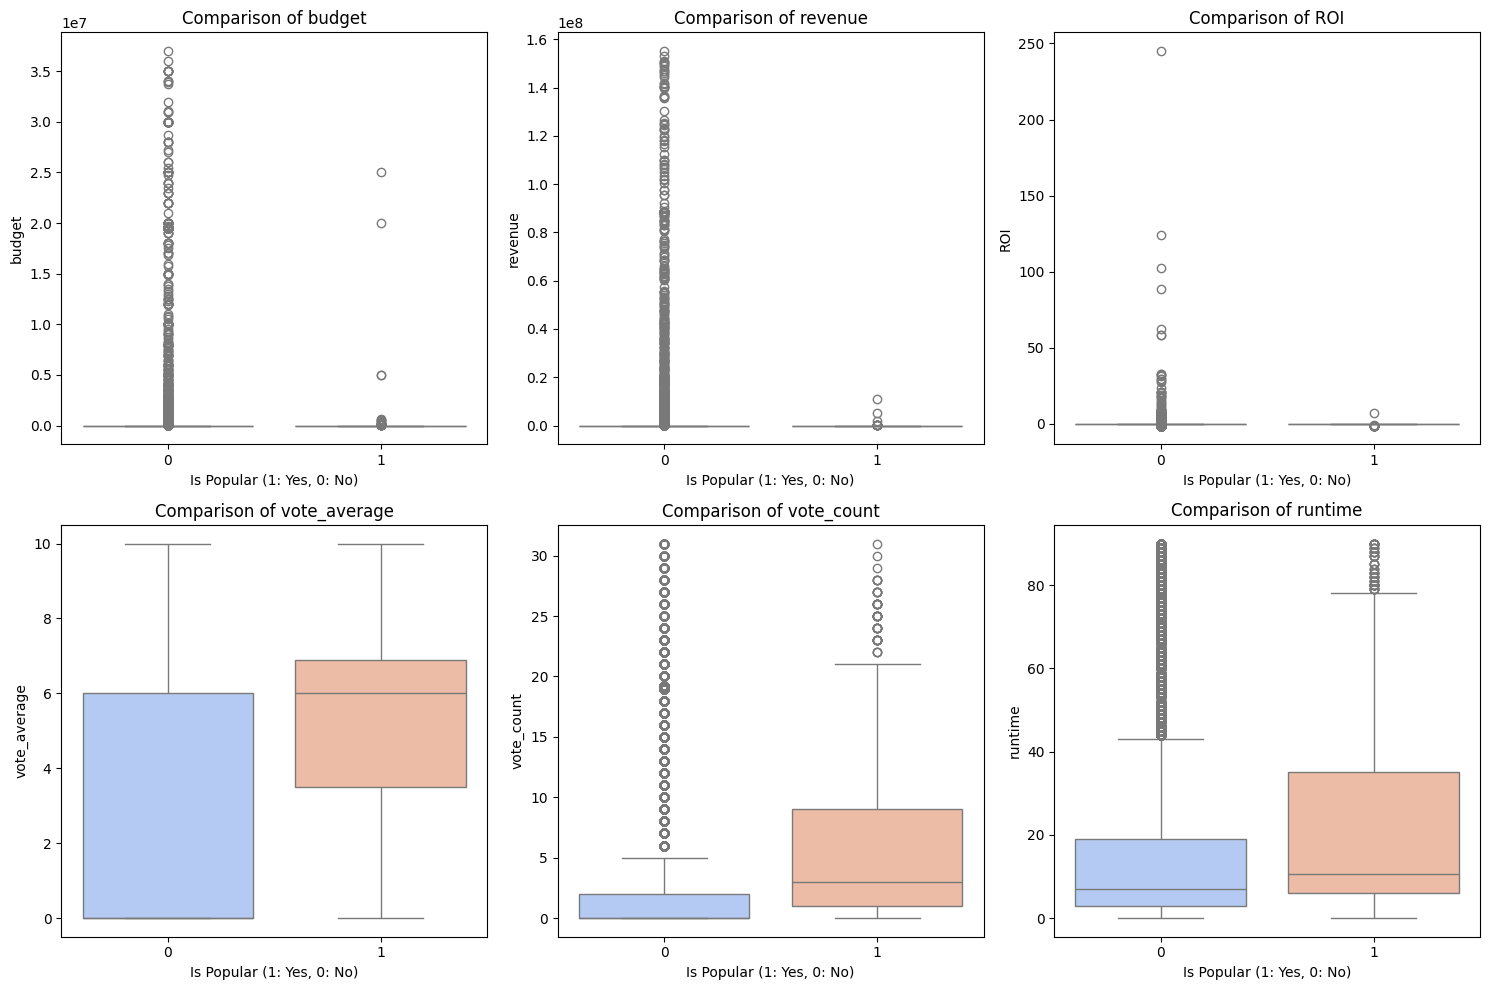


Statistical Analysis of Key Features for Successful vs Unsuccessful Movies:
is_popular                     0             1
budget       count  4.862200e+04  1.186000e+03
             mean   2.045764e+05  4.911678e+04
             std    1.981671e+06  9.517705e+05
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    3.700000e+07  2.500000e+07
revenue      count  4.862200e+04  1.186000e+03
             mean   7.034400e+05  1.592035e+04
             std    7.587037e+06  3.550394e+05
             min    0.000000e+00  0.000000e+00
             25%    0.000000e+00  0.000000e+00
             50%    0.000000e+00  0.000000e+00
             75%    0.000000e+00  0.000000e+00
             max    1.551526e+08  1.084913e+07
ROI          count  4.862200e+04  1.186000e+03
             mean   3.149274e-02 -1.082573e-02
             std    1.590953e+

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Step 3: Feature Importance from Decision Tree
print("\nAnalyzing Feature Importance from Decision Tree...")
dt_feature_importances = pd.Series(best_dt.feature_importances_, index=selected_features)
dt_feature_importances = dt_feature_importances.sort_values(ascending=False)

# Visualize Decision Tree Feature Importance
plt.figure(figsize=(12, 6))
bars = dt_feature_importances.head(10).plot(kind='bar', colormap="coolwarm", edgecolor='black')
plt.title("Top 10 Features Contributing to Movie Success (Decision Tree)", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Add value labels to the bars
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.2f}",
        ha='center', va='bottom', fontsize=10
    )

plt.show()

# Step 4: SVM Feature Importance (via Coefficients for Linear Kernel)
if best_svm.kernel == 'linear':
    print("\nAnalyzing Feature Importance from SVM (Linear Kernel)...")
    svm_feature_importances = pd.Series(best_svm.coef_[0], index=selected_features)
    svm_feature_importances = svm_feature_importances.sort_values(ascending=False)

    # Visualize SVM Feature Importance
    plt.figure(figsize=(12, 6))
    bars = svm_feature_importances.head(10).plot(kind='bar', colormap="coolwarm", edgecolor='black')
    plt.title("Top 10 Features Contributing to Movie Success (SVM - Linear Kernel)", fontsize=14)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Coefficient Value", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()

    # Add value labels to the bars
    for bar in bars.patches:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{bar.get_height():.2f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

# Step 5: Analyze Predictions for Naive Bayes
print("\nAnalyzing Predictions from Naive Bayes...")
nb_predictions = best_nb.predict(X_test)
naive_bayes_stats = pd.DataFrame({
    "Predictions": nb_predictions,
    "Actual": y_test
})

# Step 6: Visualize Key Features for Successful vs. Unsuccessful Movies
key_features = ['budget', 'revenue', 'ROI', 'vote_average', 'vote_count', 'runtime']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, feature in enumerate(key_features):
    sns.boxplot(
        x='is_popular',
        y=feature,
        data=df,
        palette="coolwarm",
        ax=axes[idx // 3, idx % 3]
    )
    axes[idx // 3, idx % 3].set_title(f"Comparison of {feature}", fontsize=12)
    axes[idx // 3, idx % 3].set_xlabel("Is Popular (1: Yes, 0: No)", fontsize=10)
    axes[idx // 3, idx % 3].set_ylabel(feature, fontsize=10)
plt.tight_layout()
plt.show()

# Step 7: Statistical Analysis of Key Features
key_features_stats = df.groupby('is_popular')[key_features].describe().transpose()
print("\nStatistical Analysis of Key Features for Successful vs Unsuccessful Movies:")
print(key_features_stats)

# Step 8: Insights and Reasons for Movie Failures
print("\n--- Insights and Possible Reasons for Failure ---")
insights = [
    "1. Budget: Successful movies tend to have higher budgets compared to unsuccessful ones.",
    "2. Revenue: Successful movies generate significantly more revenue, indicating better audience reception.",
    "3. ROI: Return on Investment (ROI) is a critical factor, showing that successful movies effectively utilize their budgets.",
    "4. Vote Count and Average: Successful movies have significantly higher vote counts and averages, indicating better audience engagement and satisfaction.",
    "5. Runtime: Successful movies often have an optimal runtime, while unsuccessful ones may deviate significantly (too short or too long).",
    "6. Content Complexity: Movies with balanced content complexity (neither too simple nor overly complex) tend to succeed.",
    "7. Genre Similarity: Unsuccessful movies may target genres that are less popular or oversaturated.",
    "8. Production Companies: Established production companies play a crucial role in the success of a movie.",
    "9. Naive Bayes Insights: Predictions for unsuccessful movies often align poorly with actual outcomes, suggesting a need for better feature selection or more balanced datasets.",
    "10. SVM and Decision Tree: SVM is effective for identifying key linear separations in the data, while Decision Tree highlights non-linear dependencies."
]

# Print insights
for insight in insights:
    print(insight)


# part 2

In [23]:
# Check the distribution of the vote_average_category column
print("\nVote Average Categories Distribution:")
print(df['vote_average_category'].value_counts())

# Select relevant features for predicting vote_average_category
selected_features_vote = [
    'budget', 'revenue', 'popularity_normalized', 'runtime_normalized', 
    'content_complexity', 'genre_similarity_score', 'ROI', 
    'production_companies_encoded', 'original_language_encoded'
]

# Define features (X) and target (y)
X_vote = df[selected_features_vote]
y_vote = df['vote_average_category']



Vote Average Categories Distribution:
vote_average_category
Good         37114
Average       6840
Excellent     3970
Poor          1884
Name: count, dtype: int64


In [ ]:
# Split the dataset into train and test sets
X_train_vote, X_test_vote, y_train_vote, y_test_vote = train_test_split(
    X_vote, y_vote, test_size=0.2, random_state=42, stratify=y_vote
)

# Display the shape of the train and test sets
print(f"Train set size: {X_train_vote.shape[0]} samples")
print(f"Test set size: {X_test_vote.shape[0]} samples")


Train set size: 39846 samples
Test set size: 9962 samples


In [25]:
scaler_vote = StandardScaler()

# Standardize the training and testing sets
X_train_scaled_vote = scaler_vote.fit_transform(X_train_vote)
X_test_scaled_vote = scaler_vote.transform(X_test_vote)

print("Feature scaling completed.")


Feature scaling completed.


In [28]:
# Define models with balanced class weights where applicable
models_vote = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "SVM": SVC(random_state=42, class_weight="balanced"),
    "Naive Bayes": GaussianNB()  # Naive Bayes does not use class weights
}

# Train models and calculate training accuracy
train_accuracies_vote = {}
for model_name, model in models_vote.items():
    print(f"\nTraining {model_name}...")
    # Fit the model (scaled data for SVM, unscaled for Naive Bayes)
    model.fit(X_train_scaled_vote if model_name != "Naive Bayes" else X_train_vote, y_train_vote)
    # Predict on training data
    y_train_pred_vote = model.predict(X_train_scaled_vote if model_name != "Naive Bayes" else X_train_vote)
    # Calculate accuracy
    train_accuracy_vote = accuracy_score(y_train_vote, y_train_pred_vote)
    train_accuracies_vote[model_name] = train_accuracy_vote
    print(f"{model_name} Train Accuracy: {train_accuracy_vote:.4f}")

# Display training accuracies
print("\nTraining Accuracies:")
for model_name, accuracy in train_accuracies_vote.items():
    print(f"{model_name}: {accuracy:.4f}")



Training Decision Tree...
Decision Tree Train Accuracy: 0.8793

Training SVM...
SVM Train Accuracy: 0.4735

Training Naive Bayes...
Naive Bayes Train Accuracy: 0.0452

Training Accuracies:
Decision Tree: 0.8793
SVM: 0.4735
Naive Bayes: 0.0452


In [30]:
# Set up cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Decision Tree Hyperparameter Tuning
print("\nTuning Decision Tree...")
dt_param_grid = {
    "max_depth": [5, 10, 15],
    "min_samples_split": [10, 20, 50],
    "min_samples_leaf": [5, 10, 20],
    "ccp_alpha": [0.0, 0.01, 0.1]  # Cost-complexity pruning
}
dt_grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=dt_param_grid,
    cv=stratified_kfold,
    scoring="accuracy",
    n_jobs=-1
)
dt_grid_search.fit(X_train_scaled_vote, y_train_vote)
best_dt_vote = dt_grid_search.best_estimator_
print("Best Decision Tree Parameters:", dt_grid_search.best_params_)

# Quick SVM Hyperparameter Tuning
print("\nQuick Tuning SVM...")
quick_svm_param_grid = {
    "C": [0.1],  # Smaller range of `C`
    "kernel": ["rbf"]  # Only linear kernel for simplicity
}
quick_svm_grid_search = GridSearchCV(
    SVC(random_state=42, class_weight="balanced"),
    param_grid=quick_svm_param_grid,
    cv=3,  # Faster execution with 3-fold cross-validation
    scoring="accuracy",
    n_jobs=-1
)
quick_svm_grid_search.fit(X_train_scaled_vote, y_train_vote)
best_quick_svm_vote = quick_svm_grid_search.best_estimator_
print("Quick SVM Parameters:", quick_svm_grid_search.best_params_)

# Detailed SVM Hyperparameter Tuning (Commented Out)
"""
print("\nDetailed Tuning SVM...")
detailed_svm_param_grid = {
    "C": [0.1, 1, 10],  # Wider range of `C`
    "kernel": ["linear", "rbf"],  # Linear and RBF kernels
    "gamma": [0.01, 0.1, 1]  # Gamma values for RBF kernel
}
detailed_svm_grid_search = GridSearchCV(
    SVC(random_state=42, class_weight="balanced"),
    param_grid=detailed_svm_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1
)
detailed_svm_grid_search.fit(X_train_scaled_vote, y_train_vote)
best_detailed_svm_vote = detailed_svm_grid_search.best_estimator_
print("Detailed SVM Parameters:", detailed_svm_grid_search.best_params_)
"""

# Select the desired version of SVM (default to quick)
best_svm_vote = best_quick_svm_vote  # Use the quick version
# best_svm_vote = best_detailed_svm_vote  # Uncomment to use the detailed version

# Naive Bayes Hyperparameter Tuning
print("\nTuning Naive Bayes...")
nb_param_grid = {
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Range for smoothing parameter
}
nb_grid_search = GridSearchCV(
    GaussianNB(),
    param_grid=nb_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
nb_grid_search.fit(X_train_vote, y_train_vote)
best_nb_vote = nb_grid_search.best_estimator_
print("Best Naive Bayes Parameters:", nb_grid_search.best_params_)

# Save tuned models
tuned_models_vote = {
    "Decision Tree": best_dt_vote,
    "SVM": best_svm_vote,
    "Naive Bayes": best_nb_vote,
}

# Evaluate tuned models on the training set
print("\nEvaluating Tuned Models on Training Set:")
for model_name, model in tuned_models_vote.items():
    if model_name == "Naive Bayes":
        train_accuracy_vote = model.score(X_train_vote, y_train_vote)
    else:
        train_accuracy_vote = model.score(X_train_scaled_vote, y_train_vote)
    print(f"{model_name} Train Accuracy: {train_accuracy_vote:.4f}")



Tuning Decision Tree...
Best Decision Tree Parameters: {'ccp_alpha': 0.01, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}

Quick Tuning SVM...
Quick SVM Parameters: {'C': 0.1, 'kernel': 'rbf'}

Tuning Naive Bayes...
Best Naive Bayes Parameters: {'var_smoothing': 1e-07}

Evaluating Tuned Models on Training Set:
Decision Tree Train Accuracy: 0.6013
SVM Train Accuracy: 0.4593
Naive Bayes Train Accuracy: 0.0451


In [31]:
# Function to evaluate a model on the test set
def evaluate_model(model, X_test, y_test, model_name, scaled_data=None):
    """
    Evaluate the given model on the test set and calculate key metrics.
    """
    print(f"\nEvaluating {model_name} on Test Set...")

    # Determine which test data to use
    X_test_data = scaled_data if scaled_data is not None else X_test

    # Generate predictions
    y_pred = model.predict(X_test_data)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=1)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=1)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=1)

    # Print metrics
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    }

# Evaluate Decision Tree
dt_test_results_vote = evaluate_model(
    model=best_dt_vote, 
    X_test=X_test_vote, 
    y_test=y_test_vote, 
    model_name="Decision Tree", 
    scaled_data=X_test_scaled_vote
)

# Evaluate SVM
svm_test_results_vote = evaluate_model(
    model=best_svm_vote, 
    X_test=X_test_vote, 
    y_test=y_test_vote, 
    model_name="SVM", 
    scaled_data=X_test_scaled_vote
)

# Evaluate Naive Bayes
nb_test_results_vote = evaluate_model(
    model=best_nb_vote, 
    X_test=X_test_vote, 
    y_test=y_test_vote, 
    model_name="Naive Bayes", 
    scaled_data=None
)

# Summarize results
test_results_vote = {
    "Decision Tree": dt_test_results_vote,
    "SVM": svm_test_results_vote,
    "Naive Bayes": nb_test_results_vote,
}

print("\n--- Summary of Test Results ---")
for model_name, metrics in test_results_vote.items():
    print(f"\nModel: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")



Evaluating Decision Tree on Test Set...
Decision Tree Test Accuracy: 0.6004
Precision: 0.7678, Recall: 0.6004, F1-Score: 0.6078

Classification Report:
              precision    recall  f1-score   support

     Average       0.22      0.62      0.33      1368
   Excellent       1.00      0.00      0.00       794
        Good       0.83      0.69      0.76      7423
        Poor       1.00      0.00      0.00       377

    accuracy                           0.60      9962
   macro avg       0.76      0.33      0.27      9962
weighted avg       0.77      0.60      0.61      9962


Evaluating SVM on Test Set...
SVM Test Accuracy: 0.4616
Precision: 0.6762, Recall: 0.4616, F1-Score: 0.5304

Classification Report:
              precision    recall  f1-score   support

     Average       0.24      0.30      0.26      1368
   Excellent       0.16      0.41      0.23       794
        Good       0.84      0.51      0.63      7423
        Poor       0.06      0.26      0.09       377

    acc


Analyzing Feature Importance from Decision Tree...


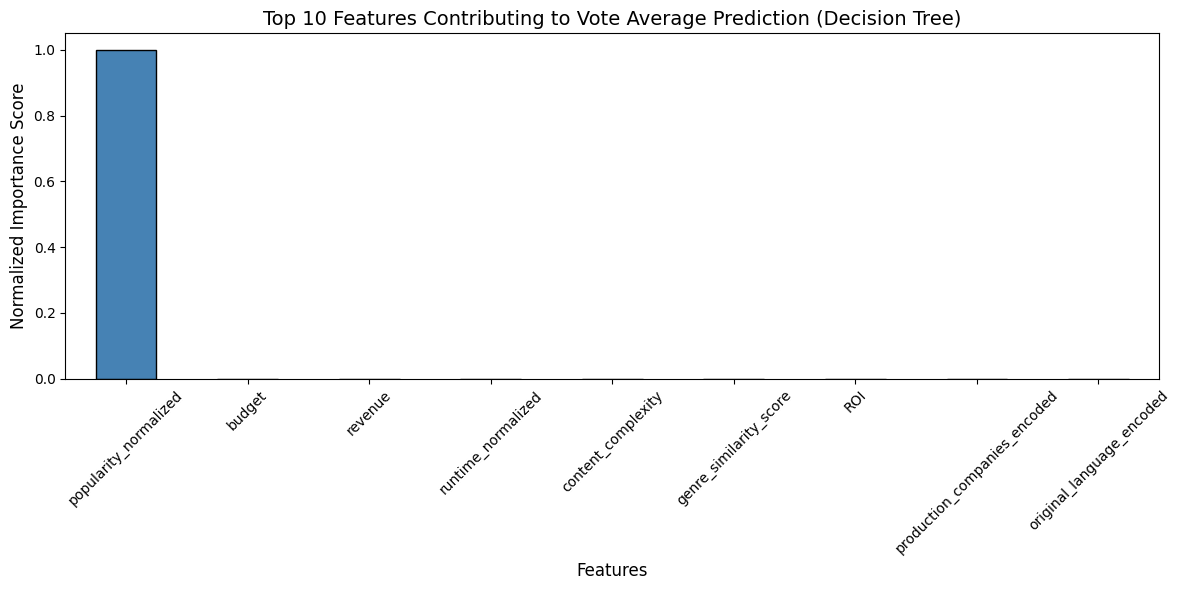


Analyzing Predictions from Naive Bayes...


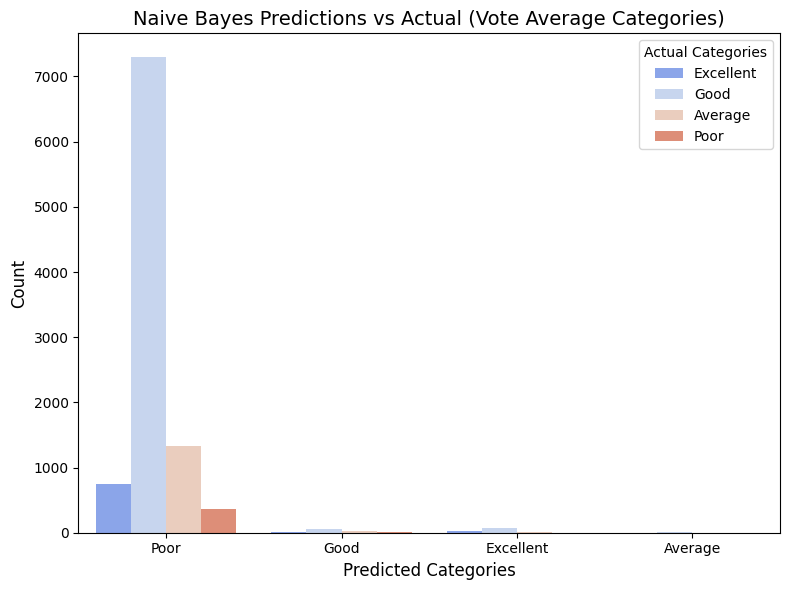

C:\Users\Pooria\AppData\Local\Temp\ipykernel_24772\536594662.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Pooria\AppData\Local\Temp\ipykernel_24772\536594662.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


KeyError: 'vote_count'

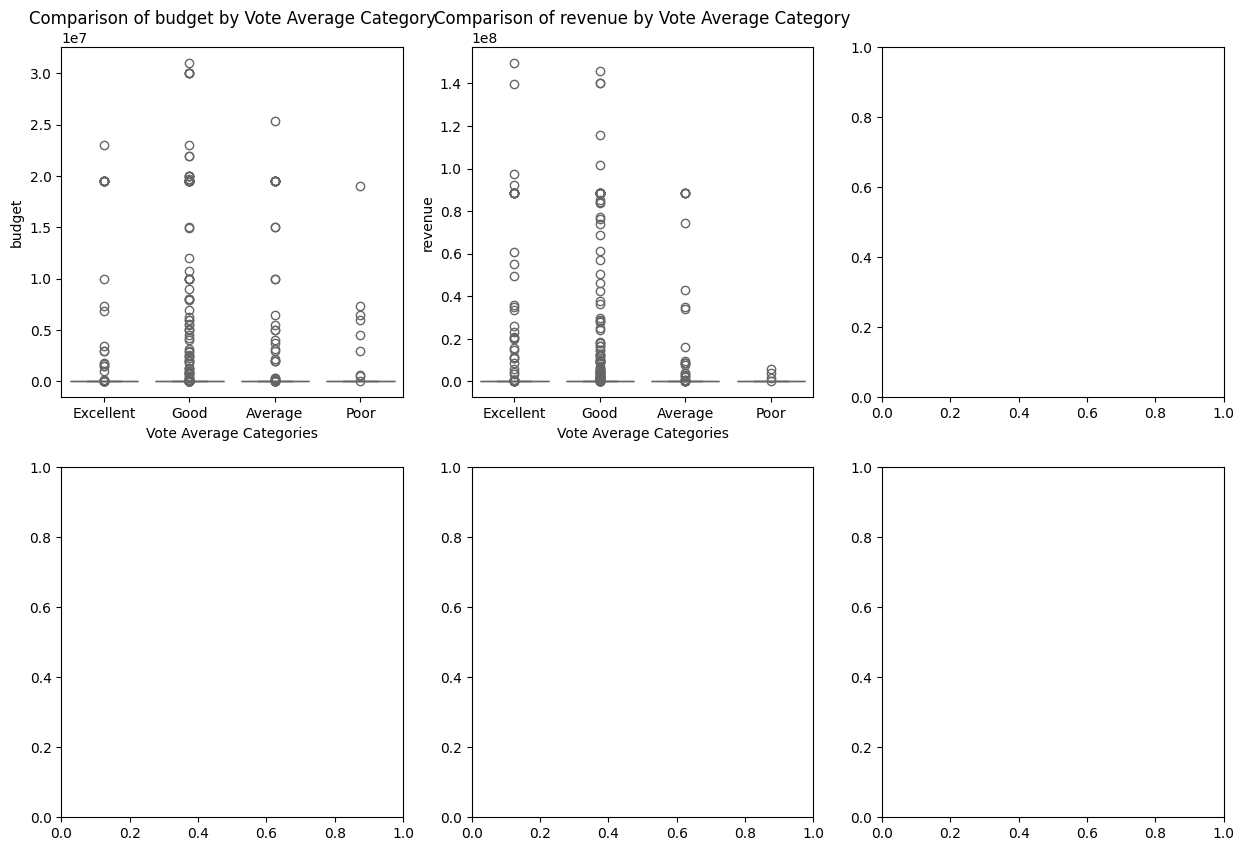

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Feature Importance from Decision Tree
print("\nAnalyzing Feature Importance from Decision Tree...")
dt_feature_importances_vote = pd.Series(best_dt_vote.feature_importances_, index=selected_features_vote)
dt_feature_importances_vote = dt_feature_importances_vote.sort_values(ascending=False)

# Normalize feature importance for better visualization
dt_feature_importances_normalized_vote = dt_feature_importances_vote / dt_feature_importances_vote.sum()

# Visualize Decision Tree Feature Importance
plt.figure(figsize=(12, 6))
dt_feature_importances_normalized_vote.head(10).plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Top 10 Features Contributing to Vote Average Prediction (Decision Tree)", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Normalized Importance Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

# Step 2: Feature Importance from SVM (if using linear kernel)
if best_svm_vote.kernel == 'linear':
    print("\nAnalyzing Feature Importance from SVM (Linear Kernel)...")
    svm_feature_importances_vote = pd.Series(best_svm_vote.coef_[0], index=selected_features_vote)
    svm_feature_importances_vote = svm_feature_importances_vote.sort_values(ascending=False)

    # Normalize SVM coefficients
    svm_feature_importances_normalized_vote = svm_feature_importances_vote / svm_feature_importances_vote.abs().sum()

    # Visualize SVM Feature Importance
    plt.figure(figsize=(12, 6))
    svm_feature_importances_normalized_vote.head(10).plot(kind='bar', color='darkorange', edgecolor='black')
    plt.title("Top 10 Features Contributing to Vote Average Prediction (SVM - Linear Kernel)", fontsize=14)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Normalized Coefficient Value", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

# Step 3: Analyzing Predictions from Naive Bayes
print("\nAnalyzing Predictions from Naive Bayes...")
nb_predictions_vote = best_nb_vote.predict(X_test_vote)
naive_bayes_stats_vote = pd.DataFrame({
    "Predictions": nb_predictions_vote,
    "Actual": y_test_vote
})

# Visualize predictions for successful vs. unsuccessful classifications
plt.figure(figsize=(8, 6))
sns.countplot(data=naive_bayes_stats_vote, x="Predictions", hue="Actual", palette="coolwarm")
plt.title("Naive Bayes Predictions vs Actual (Vote Average Categories)", fontsize=14)
plt.xlabel("Predicted Categories", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Actual Categories", fontsize=10)
plt.tight_layout()
plt.show()

# Step 4: Visualizing Key Features for Successful vs Unsuccessful Movies
key_features_vote = ['budget', 'revenue', 'vote_count', 'runtime', 'popularity_normalized']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, feature in enumerate(key_features_vote):
    sns.boxplot(
        x=y_test_vote,
        y=X_test_vote[feature],
        palette="coolwarm",
        ax=axes[idx // 3, idx % 3]
    )
    axes[idx // 3, idx % 3].set_title(f"Comparison of {feature} by Vote Average Category", fontsize=12)
    axes[idx // 3, idx % 3].set_xlabel("Vote Average Categories", fontsize=10)
    axes[idx // 3, idx % 3].set_ylabel(feature, fontsize=10)
plt.tight_layout()
plt.show()
